In [1]:
import random, gc, os, pickle, csv, time

import datasets.utils
import models.utils
from models.cls_oml_ori_v2 import OML
from models.base_models_ori import LabelAwareReplayMemory

import numpy as np
import matplotlib.pyplot as plt

import higher
import torch
import torch.nn.functional as F
from torch.utils import data

# Constants

In [2]:
dataset_order_mapping = {
    1: [2, 0, 3, 1, 4],
    2: [3, 4, 0, 1, 2],
    3: [2, 4, 1, 3, 0],
    4: [0, 2, 1, 4, 3]
}
n_classes = 33
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
# model_path = "/data/model_runs/original_oml/aOML-order1-2022-07-18/OML-order1-id4-2022-07-18_17-53-13.518612.pt"
# model_path = "/data/model_runs/original_oml/aOML-order1-inlr002-2022-07-31/OML-order1-id4-2022-07-31_14-53-46.456804.pt"
# model_path = "/data/model_runs/original_oml/aOML-order1-inlr005-2022-07-31/OML-order1-id4-2022-07-31_18-47-41.477968.pt"
# model_path = "/data/model_runs/original_oml/aOML-order1-inlr005-up20-2022-08-01/OML-order1-id4-2022-08-01_14-45-55.869765.pt"
# model_path = "/data/model_runs/original_oml/aOML-order1-inlr010-2022-07-31/OML-order1-id4-2022-07-31_21-18-36.241546.pt"
# model_path = "/data/model_runs/original_oml/aOML-order1-inlr020-2022-08-16/OML-order1-id4-2022-08-16_11-37-19.424113.pt"
# model_path = "/data/model_runs/original_oml/aOML-order1-inlr050-2022-08-16/OML-order1-id4-2022-08-16_14-16-12.167637.pt"

# v. SR 
# model_path = "/data/model_runs/original_oml/aOML-order1-inlr010-2022-08-29-sr/OML-order1-id4-2022-08-29_18-10-31.695669.pt"
# v. SR Query
model_path = "/data/model_runs/original_oml/aOML-order1-inlr010-2022-08-30-sr-query/OML-order1-id4-2022-08-30_05-21-18.854228.pt"

# memory_path = "/data/model_runs/original_oml/aOML-order1-2022-07-18/OML-order1-id4-2022-07-18_17-53-13.518639_memory.pickle"
# memory_path = "/data/model_runs/original_oml/aOML-order1-inlr002-2022-07-31/OML-order1-id4-2022-07-31_14-53-46.456828_memory.pickle"
# memory_path = "/data/model_runs/original_oml/aOML-order1-inlr005-2022-07-31/OML-order1-id4-2022-07-31_18-47-41.477992_memory.pickle"
# memory_path = "/data/model_runs/original_oml/aOML-order1-inlr005-up20-2022-08-01/OML-order1-id4-2022-08-01_14-45-55.869797_memory.pickle"
# memory_path = "/data/model_runs/original_oml/aOML-order1-inlr010-2022-07-31/OML-order1-id4-2022-07-31_21-18-36.241572_memory.pickle"
# memory_path = "/data/model_runs/original_oml/aOML-order1-inlr020-2022-08-16/OML-order1-id4-2022-08-16_11-37-19.424139_memory.pickle"
# memory_path = "/data/model_runs/original_oml/aOML-order1-inlr050-2022-08-16/OML-order1-id4-2022-08-16_14-16-12.167666_memory.pickle"
# v. SR 
# memory_path = "/data/model_runs/original_oml/aOML-order1-inlr010-2022-08-29-sr/OML-order1-id4-2022-08-29_18-10-31.695692_memory.pickle"
# v. SR Query
memory_path = "/data/model_runs/original_oml/aOML-order1-inlr010-2022-08-30-sr-query/OML-order1-id4-2022-08-30_05-21-18.854254_memory.pickle"


# new_memory_path, ext = os.path.splitext(memory_path)
# new_memory_path = new_memory_path + "_label" + ext

use_db_cache = True
cache_dir = 'tmp'

In [3]:
args = {
    "order": 1,
    "n_epochs": 1,
    "lr": 3e-5,
    "inner_lr": 0.001*10,
    "meta_lr": 3e-5,
    "model": "bert",
    "learner": "oml",
    "mini_batch_size": 16,
    "updates": 5*1,
    "write_prob": 1.0,
    "max_length": 448,
    "seed": 42,
    "replay_rate": 0.01,
    "replay_every": 9600
}
updates = args["updates"]
mini_batch_size = args["mini_batch_size"]
order = args["order"]

In [4]:
torch.manual_seed(args["seed"])
random.seed(args["seed"])
np.random.seed(args["seed"])

# Load Dataset

In [5]:
print('Loading the datasets')
test_datasets = []
for dataset_id in dataset_order_mapping[order]:
    test_dataset_file = os.path.join(cache_dir, f"{dataset_id}.cache")
    if os.path.exists(test_dataset_file):
        with open(test_dataset_file, 'rb') as f:
            test_dataset = pickle.load(f)
    else:
        test_dataset = datasets.utils.get_dataset_test("", dataset_id)
        print('Loaded {}'.format(test_dataset.__class__.__name__))
        test_dataset = datasets.utils.offset_labels(test_dataset)
        pickle.dump(test_dataset, open( test_dataset_file, "wb" ), protocol=pickle.HIGHEST_PROTOCOL)
        print(f"Pickle saved at {test_dataset_file}")
    test_datasets.append(test_dataset)
print('Finished loading all the datasets')

Loading the datasets
Finished loading all the datasets


# Load Model

In [6]:
learner = OML(device=device, n_classes=n_classes, **args)
print('Using {} as learner'.format(learner.__class__.__name__))
learner.load_model(model_path)
with open(memory_path, 'rb') as f:
#     learner.memory = pickle.load(f)
    memory_buffer = pickle.load(f)


2022-11-28 12:33:36,491 - transformers.tokenization_utils_base - INFO - loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at /root/.cache/torch/transformers/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084
2022-11-28 12:33:37,785 - transformers.configuration_utils - INFO - loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-config.json from cache at /root/.cache/torch/transformers/4dad0251492946e18ac39290fcfe91b89d370fee250efe9521476438fe8ca185.7156163d5fdc189c3016baca0775ffce230789d7fa2a42ef516483e4ca884517
2022-11-28 12:33:37,788 - transformers.configuration_utils - INFO - Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer

Using OML as learner


In [7]:
# Setting up task dict for task-aware
memory_buffer.task_dict = {
    0: list(range(5, 9)), # AG
    1: list(range(0, 5)), # Amazon
    2: list(range(0, 5)), # Yelp
    3: list(range(9, 23)), # DBPedia
    4: list(range(23, 33)), # Yahoo
}

In [8]:
# label to task converter - hack, since normally we would just use the task token/identifier
def get_task_from_label(label_idx, task_dict):
    for task_idx, class_list in task_dict.items():
        if label_idx in class_list: return task_idx
    return -1
print(get_task_from_label(8, memory_buffer.task_dict))
# Find mode: https://stackoverflow.com/questions/10797819/finding-the-mode-of-a-list
def mode(array):
    return max(array, key = array.count)
# label list to task id
def get_task_from_label_list(label_list, task_dict):
    return mode([get_task_from_label(label, task_dict) for label in label_list])
print(get_task_from_label_list([1,2,32,1,4,2,0], memory_buffer.task_dict))

0
1


In [9]:
dataclass_mapper = {
    "AGNewsDataset": 0,
    "AmazonDataset": 1,
    "YelpDataset": 2,
    "DBPediaDataset": 3,
    "YahooAnswersDataset": 4
}
dataclass_mapper["AGNewsDataset"]

0

In [10]:
# Trim buffer dict to 1000 per class
memory_buffer.reset_meta()
memory_buffer.trim_buffer_dict(limit_n=300)

In [11]:
len(memory_buffer.buffer_dict[0])

300

# Get Scores for each sample in ER

In [12]:
# Returns loss,preds,labels, labels_conf
def validate(fpln, validation_set):
    all_valid_preds, all_valid_labels, all_valid_label_conf = [], [], []
    
    for valid_text, valid_labels, _ in validation_set:        
        valid_labels = torch.tensor(valid_labels).to(device)
        valid_input_dict = learner.rln.encode_text(valid_text)
        valid_repr = learner.rln(valid_input_dict)
        valid_output = fpln(valid_repr) # Output has size of torch.Size([16, 33]) [BATCH, CLASSES]
        valid_loss = learner.loss_fn(valid_output, valid_labels)
        valid_loss = valid_loss.item()

        # output.detach().max(-1) max on each Batch, which will return [0] max, [1] indices
        valid_output_softmax = F.softmax(valid_output, -1)
        valid_label_conf = valid_output_softmax[np.arange(len(valid_output_softmax)), valid_labels] # Select labels in the softmax of 33 classes

        valid_pred = models.utils.make_prediction(valid_output.detach())
        
        
        # Put in things to return
        # all_valid_losses.extend(valid_loss)
        all_valid_preds.extend(valid_pred.tolist())
        all_valid_labels.extend(valid_labels.tolist())
        all_valid_label_conf.extend(valid_label_conf.tolist())
    return all_valid_preds, all_valid_labels, all_valid_label_conf # removed loss, since no need

# Compare diff results between the unadapted vs adapted
# Returns Dictionary of class_idx -> [ a - n, ...  ] for each i (300). Can np.sum() or np.mean() later
# validate_labels = The labels (Shared)
# validate_label_conf_0 = The label conf of validate_0
# validate_label_conf_n = The label conf of validate_n
def calculate_diff_class(validate_labels, validate_label_conf_0, validate_label_conf_n, initial_dict={}, return_dict=True): 
    # Adapted confs - NonAdapted Confs (a-n)
    validate_label_conf_diff = np.array(validate_label_conf_n) - np.array(validate_label_conf_0)
    
    if return_dict:
        # The dictionary to return  class_idx -> [ a - n, ...  ] 
        return_dict = initial_dict.copy()
        for i, class_idx in enumerate(validate_labels):
            # Filter conf_diff by class
            return_dict[class_idx] = return_dict.get(class_idx, []) + [validate_label_conf_diff[i]]
        return return_dict
    
    return validate_label_conf_diff

Every Task, we do `16*1 = 16` batch , there are 5 tasks so `16*5 = 80` per epoch (takes around 0.2s per task ~1s). So we need to do it 300 times so that it will be ~5 minutes (300s) and it means `80*300 = 24,000`, and hopefully support will be around  `16*300/300 ~ 16` per sample.

```
Adapt Time: 0.165510892868042 s
Support set metrics: Loss = 0.3509, accuracy = 0.9375, precision = 0.9500, recall = 0.9375, F1 score = 0.9365
```

In [13]:
TOTAL_EPOCH = 300
for epoch in range(TOTAL_EPOCH):
    print(f"This is epoch {epoch}/{TOTAL_EPOCH}")
    learner.rln.eval()
    learner.pln.train()
    
    for task_idx in memory_buffer.task_dict.keys():
        support_set = []
        #for _ in range(updates):
        for _ in range(1): # CHANGE THIS to 1 minibatch.
            text, labels, indexes = memory_buffer.read_batch_task(batch_size=mini_batch_size, task_idx=task_idx, \
                                                                  with_index=True)
            support_set.append((text, labels, indexes))
        
        with higher.innerloop_ctx(learner.pln, learner.inner_optimizer,
                                  copy_initial_weights=False, track_higher_grads=False) as (fpln, diffopt):
            
            # Test validation_set BEFORE the update (update=0)
            with torch.no_grad():
                all_valid_preds_0, all_valid_labels_0, all_valid_label_conf_0  = validate(fpln, support_set)
            
            INNER_tic = time.time()
            # Inner loop
            task_predictions, task_labels, task_indexes = [], [], []
            support_loss = []
            for text, labels, indexes in support_set:
                labels = torch.tensor(labels).to(device)
                input_dict = learner.rln.encode_text(text)
                _repr = learner.rln(input_dict)
                output = fpln(_repr)
                loss = learner.loss_fn(output, labels)
                diffopt.step(loss)
                pred = models.utils.make_prediction(output.detach())
                support_loss.append(loss.item())
                task_predictions.extend(pred.tolist())
                task_labels.extend(labels.tolist())
                task_indexes.extend(indexes)
            INNER_toc = time.time() - INNER_tic
            print("Adapt Time: "+ str(INNER_toc) +" s" )
            
            # Test validation_set AFTER ALL the update
            with torch.no_grad():
                all_valid_preds_n, all_valid_labels_n, all_valid_label_conf_n = validate(fpln, support_set)
                diff_list = calculate_diff_class(all_valid_labels_0, all_valid_label_conf_0, all_valid_label_conf_n, return_dict=False)
                memory_buffer.update_meta(all_valid_labels_0, task_indexes, diff_list)

            acc, prec, rec, f1 = models.utils.calculate_metrics(task_predictions, task_labels)

            print('Support set metrics: Loss = {:.4f}, accuracy = {:.4f}, precision = {:.4f}, '
                        'recall = {:.4f}, F1 score = {:.4f}'.format(np.mean(support_loss), acc, prec, rec, f1))

This is epoch 0/300
Adapt Time: 0.17325139045715332 s
Support set metrics: Loss = 0.5937, accuracy = 0.8750, precision = 0.8875, recall = 0.8750, F1 score = 0.8740
Adapt Time: 0.20955157279968262 s
Support set metrics: Loss = 1.1592, accuracy = 0.6250, precision = 0.5500, recall = 0.6167, F1 score = 0.5729
Adapt Time: 0.20539522171020508 s
Support set metrics: Loss = 1.1021, accuracy = 0.5000, precision = 0.5524, recall = 0.5000, F1 score = 0.4676
Adapt Time: 0.17828917503356934 s
Support set metrics: Loss = 0.0054, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.21667861938476562 s
Support set metrics: Loss = 0.9222, accuracy = 0.7500, precision = 0.6500, recall = 0.7000, F1 score = 0.6533
This is epoch 1/300
Adapt Time: 0.17148208618164062 s
Support set metrics: Loss = 0.2536, accuracy = 0.8125, precision = 0.8250, recall = 0.8125, F1 score = 0.8115
Adapt Time: 0.20551204681396484 s
Support set metrics: Loss = 1.4166, accuracy = 0.5000, precisi

Adapt Time: 0.19861960411071777 s
Support set metrics: Loss = 0.5995, accuracy = 0.7500, precision = 0.8033, recall = 0.7500, F1 score = 0.7262
Adapt Time: 0.19976401329040527 s
Support set metrics: Loss = 0.7544, accuracy = 0.5625, precision = 0.5133, recall = 0.5500, F1 score = 0.5190
Adapt Time: 0.17991137504577637 s
Support set metrics: Loss = 0.0063, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.20004630088806152 s
Support set metrics: Loss = 1.2079, accuracy = 0.7500, precision = 0.6167, recall = 0.6500, F1 score = 0.6300
This is epoch 12/300
Adapt Time: 0.16860651969909668 s
Support set metrics: Loss = 0.1706, accuracy = 0.9375, precision = 0.9500, recall = 0.9375, F1 score = 0.9365
Adapt Time: 0.20355749130249023 s
Support set metrics: Loss = 1.3737, accuracy = 0.3750, precision = 0.3300, recall = 0.3667, F1 score = 0.3460
Adapt Time: 0.20389914512634277 s
Support set metrics: Loss = 0.8843, accuracy = 0.7500, precision = 0.8167, recall

Adapt Time: 0.23365283012390137 s
Support set metrics: Loss = 0.6847, accuracy = 0.7500, precision = 0.7500, recall = 0.7500, F1 score = 0.7429
Adapt Time: 0.1791520118713379 s
Support set metrics: Loss = 0.0048, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.1983339786529541 s
Support set metrics: Loss = 1.9093, accuracy = 0.4375, precision = 0.4917, recall = 0.4500, F1 score = 0.4467
This is epoch 23/300
Adapt Time: 0.16915297508239746 s
Support set metrics: Loss = 0.1718, accuracy = 0.8750, precision = 0.9167, recall = 0.8750, F1 score = 0.8667
Adapt Time: 0.20081710815429688 s
Support set metrics: Loss = 0.9549, accuracy = 0.6250, precision = 0.6867, recall = 0.6167, F1 score = 0.6024
Adapt Time: 0.19532155990600586 s
Support set metrics: Loss = 1.0603, accuracy = 0.5625, precision = 0.5200, recall = 0.5500, F1 score = 0.5067
Adapt Time: 0.17612504959106445 s
Support set metrics: Loss = 0.0066, accuracy = 1.0000, precision = 1.0000, recall =

Adapt Time: 0.1776142120361328 s
Support set metrics: Loss = 0.1574, accuracy = 0.9375, precision = 0.9643, recall = 0.9643, F1 score = 0.9524
Adapt Time: 0.21946501731872559 s
Support set metrics: Loss = 0.7711, accuracy = 0.7500, precision = 0.6833, recall = 0.7000, F1 score = 0.6600
This is epoch 34/300
Adapt Time: 0.17211270332336426 s
Support set metrics: Loss = 0.3697, accuracy = 0.8750, precision = 0.9000, recall = 0.8750, F1 score = 0.8730
Adapt Time: 0.23993992805480957 s
Support set metrics: Loss = 1.1766, accuracy = 0.5000, precision = 0.4167, recall = 0.4833, F1 score = 0.4452
Adapt Time: 0.19415879249572754 s
Support set metrics: Loss = 0.8736, accuracy = 0.6250, precision = 0.5833, recall = 0.6000, F1 score = 0.5457
Adapt Time: 0.18497061729431152 s
Support set metrics: Loss = 0.0053, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.22383427619934082 s
Support set metrics: Loss = 0.9527, accuracy = 0.7500, precision = 0.6667, recall 

Adapt Time: 0.21420788764953613 s
Support set metrics: Loss = 0.6264, accuracy = 0.8125, precision = 0.7667, recall = 0.8000, F1 score = 0.7633
This is epoch 45/300
Adapt Time: 0.16821002960205078 s
Support set metrics: Loss = 0.2867, accuracy = 0.9375, precision = 0.9500, recall = 0.9375, F1 score = 0.9365
Adapt Time: 0.2014756202697754 s
Support set metrics: Loss = 0.9662, accuracy = 0.5000, precision = 0.5667, recall = 0.5167, F1 score = 0.4895
Adapt Time: 0.18830108642578125 s
Support set metrics: Loss = 0.8991, accuracy = 0.6875, precision = 0.5733, recall = 0.6833, F1 score = 0.6167
Adapt Time: 0.18360662460327148 s
Support set metrics: Loss = 0.0076, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.20029306411743164 s
Support set metrics: Loss = 0.9464, accuracy = 0.7500, precision = 0.7167, recall = 0.8000, F1 score = 0.7300
This is epoch 46/300
Adapt Time: 0.16755104064941406 s
Support set metrics: Loss = 0.2078, accuracy = 0.9375, precis

Adapt Time: 0.17543363571166992 s
Support set metrics: Loss = 0.0549, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.19748449325561523 s
Support set metrics: Loss = 0.7636, accuracy = 0.7500, precision = 0.7800, recall = 0.7333, F1 score = 0.7278
Adapt Time: 0.19049406051635742 s
Support set metrics: Loss = 1.1559, accuracy = 0.6250, precision = 0.6867, recall = 0.6333, F1 score = 0.6119
Adapt Time: 0.17104172706604004 s
Support set metrics: Loss = 0.0687, accuracy = 0.9375, precision = 0.9048, recall = 0.9286, F1 score = 0.9143
Adapt Time: 0.19968867301940918 s
Support set metrics: Loss = 1.0204, accuracy = 0.7500, precision = 0.6333, recall = 0.7000, F1 score = 0.6433
This is epoch 57/300
Adapt Time: 0.1686556339263916 s
Support set metrics: Loss = 0.2367, accuracy = 0.8750, precision = 0.9167, recall = 0.8750, F1 score = 0.8786
Adapt Time: 0.1883866786956787 s
Support set metrics: Loss = 1.1258, accuracy = 0.5000, precision = 0.5167, recall =

Adapt Time: 0.19858407974243164 s
Support set metrics: Loss = 0.9988, accuracy = 0.6250, precision = 0.7033, recall = 0.6167, F1 score = 0.6181
Adapt Time: 0.20682764053344727 s
Support set metrics: Loss = 1.3263, accuracy = 0.5625, precision = 0.5533, recall = 0.5333, F1 score = 0.4900
Adapt Time: 0.1792454719543457 s
Support set metrics: Loss = 0.0242, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.20270609855651855 s
Support set metrics: Loss = 1.1539, accuracy = 0.6875, precision = 0.6333, recall = 0.6500, F1 score = 0.6100
This is epoch 68/300
Adapt Time: 0.16913080215454102 s
Support set metrics: Loss = 0.1501, accuracy = 0.9375, precision = 0.9500, recall = 0.9375, F1 score = 0.9365
Adapt Time: 0.17721772193908691 s
Support set metrics: Loss = 0.7840, accuracy = 0.5625, precision = 0.4667, recall = 0.5333, F1 score = 0.4952
Adapt Time: 0.2183380126953125 s
Support set metrics: Loss = 1.3069, accuracy = 0.3750, precision = 0.3067, recall =

Adapt Time: 0.19907450675964355 s
Support set metrics: Loss = 1.2290, accuracy = 0.3750, precision = 0.2500, recall = 0.3333, F1 score = 0.2849
Adapt Time: 0.17340683937072754 s
Support set metrics: Loss = 0.0061, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.20773744583129883 s
Support set metrics: Loss = 1.4864, accuracy = 0.6250, precision = 0.5000, recall = 0.6000, F1 score = 0.5400
This is epoch 79/300
Adapt Time: 0.16649198532104492 s
Support set metrics: Loss = 0.0625, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.21223998069763184 s
Support set metrics: Loss = 0.9751, accuracy = 0.5625, precision = 0.4133, recall = 0.5333, F1 score = 0.4611
Adapt Time: 0.19653773307800293 s
Support set metrics: Loss = 1.0060, accuracy = 0.5625, precision = 0.4500, recall = 0.5500, F1 score = 0.4857
Adapt Time: 0.16865777969360352 s
Support set metrics: Loss = 0.0051, accuracy = 1.0000, precision = 1.0000, recall

Adapt Time: 0.17270684242248535 s
Support set metrics: Loss = 0.0084, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.19222187995910645 s
Support set metrics: Loss = 1.0672, accuracy = 0.7500, precision = 0.7667, recall = 0.7500, F1 score = 0.7300
This is epoch 90/300
Adapt Time: 0.16669392585754395 s
Support set metrics: Loss = 0.3666, accuracy = 0.9375, precision = 1.0000, recall = 0.9375, F1 score = 0.9643
Adapt Time: 0.19662022590637207 s
Support set metrics: Loss = 0.9881, accuracy = 0.6250, precision = 0.6333, recall = 0.6333, F1 score = 0.6229
Adapt Time: 0.20566201210021973 s
Support set metrics: Loss = 0.8285, accuracy = 0.6250, precision = 0.7133, recall = 0.6167, F1 score = 0.6190
Adapt Time: 0.1705760955810547 s
Support set metrics: Loss = 0.0054, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.18993687629699707 s
Support set metrics: Loss = 0.8639, accuracy = 0.8125, precision = 0.8167, recall 

Adapt Time: 0.21046161651611328 s
Support set metrics: Loss = 0.5748, accuracy = 0.6875, precision = 0.5667, recall = 0.6500, F1 score = 0.5767
This is epoch 101/300
Adapt Time: 0.16313624382019043 s
Support set metrics: Loss = 0.1215, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.18364667892456055 s
Support set metrics: Loss = 0.7483, accuracy = 0.8125, precision = 0.9000, recall = 0.8333, F1 score = 0.8267
Adapt Time: 0.213087797164917 s
Support set metrics: Loss = 1.1018, accuracy = 0.6250, precision = 0.5533, recall = 0.6333, F1 score = 0.5576
Adapt Time: 0.1872866153717041 s
Support set metrics: Loss = 0.2437, accuracy = 0.9375, precision = 1.0000, recall = 0.9643, F1 score = 0.9762
Adapt Time: 0.21069550514221191 s
Support set metrics: Loss = 0.7887, accuracy = 0.8125, precision = 0.7167, recall = 0.7500, F1 score = 0.7133
This is epoch 102/300
Adapt Time: 0.16971373558044434 s
Support set metrics: Loss = 0.1869, accuracy = 0.8750, precis

Adapt Time: 0.165907621383667 s
Support set metrics: Loss = 0.4191, accuracy = 0.8750, precision = 0.8875, recall = 0.8750, F1 score = 0.8740
Adapt Time: 0.1946713924407959 s
Support set metrics: Loss = 1.3045, accuracy = 0.3750, precision = 0.3467, recall = 0.3833, F1 score = 0.3571
Adapt Time: 0.20804858207702637 s
Support set metrics: Loss = 1.1236, accuracy = 0.5000, precision = 0.6067, recall = 0.5000, F1 score = 0.5376
Adapt Time: 0.1810445785522461 s
Support set metrics: Loss = 0.0156, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.21152734756469727 s
Support set metrics: Loss = 1.4711, accuracy = 0.6875, precision = 0.6567, recall = 0.6500, F1 score = 0.6038
This is epoch 113/300
Adapt Time: 0.16700077056884766 s
Support set metrics: Loss = 0.0826, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.20495104789733887 s
Support set metrics: Loss = 0.7852, accuracy = 0.6250, precision = 0.5533, recall = 

Adapt Time: 0.193129301071167 s
Support set metrics: Loss = 0.6820, accuracy = 0.7500, precision = 0.8200, recall = 0.7333, F1 score = 0.7243
Adapt Time: 0.20524144172668457 s
Support set metrics: Loss = 0.8221, accuracy = 0.6250, precision = 0.6967, recall = 0.6167, F1 score = 0.6167
Adapt Time: 0.16982817649841309 s
Support set metrics: Loss = 0.0048, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.21120810508728027 s
Support set metrics: Loss = 0.7007, accuracy = 0.8125, precision = 0.6833, recall = 0.7500, F1 score = 0.6933
This is epoch 124/300
Adapt Time: 0.17284536361694336 s
Support set metrics: Loss = 0.1222, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.22018098831176758 s
Support set metrics: Loss = 1.0883, accuracy = 0.4375, precision = 0.4833, recall = 0.4333, F1 score = 0.4381
Adapt Time: 0.21181249618530273 s
Support set metrics: Loss = 1.1758, accuracy = 0.5625, precision = 0.5333, recall 

Adapt Time: 0.19061613082885742 s
Support set metrics: Loss = 0.8338, accuracy = 0.5625, precision = 0.6167, recall = 0.5333, F1 score = 0.5381
Adapt Time: 0.17169404029846191 s
Support set metrics: Loss = 0.0047, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.19858455657958984 s
Support set metrics: Loss = 0.8871, accuracy = 0.7500, precision = 0.7333, recall = 0.7500, F1 score = 0.7067
This is epoch 135/300
Adapt Time: 0.16860151290893555 s
Support set metrics: Loss = 0.1293, accuracy = 0.9375, precision = 0.9500, recall = 0.9375, F1 score = 0.9365
Adapt Time: 0.2001175880432129 s
Support set metrics: Loss = 1.0970, accuracy = 0.6250, precision = 0.6033, recall = 0.6167, F1 score = 0.5981
Adapt Time: 0.19918584823608398 s
Support set metrics: Loss = 1.5230, accuracy = 0.4375, precision = 0.5000, recall = 0.4500, F1 score = 0.4667
Adapt Time: 0.17411518096923828 s
Support set metrics: Loss = 0.0273, accuracy = 1.0000, precision = 1.0000, recall

Adapt Time: 0.1811387538909912 s
Support set metrics: Loss = 0.0052, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.21694684028625488 s
Support set metrics: Loss = 0.8382, accuracy = 0.6875, precision = 0.6500, recall = 0.7500, F1 score = 0.6667
This is epoch 146/300
Adapt Time: 0.16794085502624512 s
Support set metrics: Loss = 0.2790, accuracy = 0.9375, precision = 0.9500, recall = 0.9375, F1 score = 0.9365
Adapt Time: 0.21527910232543945 s
Support set metrics: Loss = 1.0506, accuracy = 0.5625, precision = 0.5167, recall = 0.5500, F1 score = 0.5181
Adapt Time: 0.2394862174987793 s
Support set metrics: Loss = 0.8615, accuracy = 0.6250, precision = 0.5333, recall = 0.6167, F1 score = 0.5690
Adapt Time: 0.19609880447387695 s
Support set metrics: Loss = 0.0049, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.20353150367736816 s
Support set metrics: Loss = 0.4843, accuracy = 0.8125, precision = 0.8833, recall 

Adapt Time: 0.21802496910095215 s
Support set metrics: Loss = 1.0478, accuracy = 0.6250, precision = 0.5667, recall = 0.6500, F1 score = 0.5967
This is epoch 157/300
Adapt Time: 0.1703934669494629 s
Support set metrics: Loss = 0.3661, accuracy = 0.8125, precision = 0.8042, recall = 0.8125, F1 score = 0.8026
Adapt Time: 0.19858646392822266 s
Support set metrics: Loss = 0.8854, accuracy = 0.6250, precision = 0.6500, recall = 0.6500, F1 score = 0.6500
Adapt Time: 0.24184536933898926 s
Support set metrics: Loss = 0.8301, accuracy = 0.6875, precision = 0.7333, recall = 0.6833, F1 score = 0.6781
Adapt Time: 0.17801809310913086 s
Support set metrics: Loss = 0.0064, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.18648004531860352 s
Support set metrics: Loss = 0.7720, accuracy = 0.6250, precision = 0.5500, recall = 0.6000, F1 score = 0.5700
This is epoch 158/300
Adapt Time: 0.16919684410095215 s
Support set metrics: Loss = 0.4997, accuracy = 0.8750, prec

Adapt Time: 0.17325448989868164 s
Support set metrics: Loss = 0.2814, accuracy = 0.9375, precision = 0.9500, recall = 0.9375, F1 score = 0.9365
Adapt Time: 0.21657443046569824 s
Support set metrics: Loss = 1.0519, accuracy = 0.5000, precision = 0.5900, recall = 0.4833, F1 score = 0.5186
Adapt Time: 0.20326757431030273 s
Support set metrics: Loss = 0.7750, accuracy = 0.7500, precision = 0.8167, recall = 0.7667, F1 score = 0.7790
Adapt Time: 0.18204808235168457 s
Support set metrics: Loss = 0.0473, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.21606826782226562 s
Support set metrics: Loss = 1.2480, accuracy = 0.6250, precision = 0.6167, recall = 0.6000, F1 score = 0.5733
This is epoch 169/300
Adapt Time: 0.16969680786132812 s
Support set metrics: Loss = 0.2997, accuracy = 0.8750, precision = 0.9000, recall = 0.8750, F1 score = 0.8611
Adapt Time: 0.22420001029968262 s
Support set metrics: Loss = 0.6814, accuracy = 0.6875, precision = 0.7000, recal

Adapt Time: 0.18932437896728516 s
Support set metrics: Loss = 1.2051, accuracy = 0.4375, precision = 0.3633, recall = 0.4167, F1 score = 0.3833
Adapt Time: 0.20520925521850586 s
Support set metrics: Loss = 1.1580, accuracy = 0.4375, precision = 0.4833, recall = 0.4500, F1 score = 0.4576
Adapt Time: 0.18978643417358398 s
Support set metrics: Loss = 0.0058, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.2221970558166504 s
Support set metrics: Loss = 0.3136, accuracy = 0.8750, precision = 0.8000, recall = 0.8500, F1 score = 0.8167
This is epoch 180/300
Adapt Time: 0.17041397094726562 s
Support set metrics: Loss = 0.4877, accuracy = 0.9375, precision = 0.9500, recall = 0.9375, F1 score = 0.9365
Adapt Time: 0.18979430198669434 s
Support set metrics: Loss = 1.1861, accuracy = 0.5000, precision = 0.4533, recall = 0.5000, F1 score = 0.4633
Adapt Time: 0.21220827102661133 s
Support set metrics: Loss = 0.9063, accuracy = 0.5000, precision = 0.5167, recall

Adapt Time: 0.21114110946655273 s
Support set metrics: Loss = 1.3203, accuracy = 0.4375, precision = 0.5133, recall = 0.4333, F1 score = 0.4365
Adapt Time: 0.17847847938537598 s
Support set metrics: Loss = 0.0048, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.20799517631530762 s
Support set metrics: Loss = 0.6277, accuracy = 0.8125, precision = 0.8833, recall = 0.8500, F1 score = 0.8267
This is epoch 191/300
Adapt Time: 0.171281099319458 s
Support set metrics: Loss = 0.1742, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.22313809394836426 s
Support set metrics: Loss = 0.8257, accuracy = 0.6875, precision = 0.7033, recall = 0.6833, F1 score = 0.6733
Adapt Time: 0.22060179710388184 s
Support set metrics: Loss = 0.9261, accuracy = 0.6875, precision = 0.7500, recall = 0.6833, F1 score = 0.6729
Adapt Time: 0.17735958099365234 s
Support set metrics: Loss = 0.0071, accuracy = 1.0000, precision = 1.0000, recall 

Adapt Time: 0.17878341674804688 s
Support set metrics: Loss = 0.1030, accuracy = 0.9375, precision = 0.8929, recall = 0.9286, F1 score = 0.9048
Adapt Time: 0.1975846290588379 s
Support set metrics: Loss = 0.6127, accuracy = 0.8750, precision = 0.9333, recall = 0.9000, F1 score = 0.8933
This is epoch 202/300
Adapt Time: 0.17269086837768555 s
Support set metrics: Loss = 0.1434, accuracy = 0.9375, precision = 0.9500, recall = 0.9375, F1 score = 0.9365
Adapt Time: 0.23338532447814941 s
Support set metrics: Loss = 0.7364, accuracy = 0.7500, precision = 0.8200, recall = 0.7333, F1 score = 0.7243
Adapt Time: 0.19806456565856934 s
Support set metrics: Loss = 0.7910, accuracy = 0.6250, precision = 0.5500, recall = 0.6000, F1 score = 0.5657
Adapt Time: 0.1824049949645996 s
Support set metrics: Loss = 0.0056, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.21662282943725586 s
Support set metrics: Loss = 0.9684, accuracy = 0.6875, precision = 0.6833, recall 

Adapt Time: 0.21631383895874023 s
Support set metrics: Loss = 0.7789, accuracy = 0.7500, precision = 0.6750, recall = 0.7000, F1 score = 0.6833
This is epoch 213/300
Adapt Time: 0.16805553436279297 s
Support set metrics: Loss = 0.4217, accuracy = 0.8125, precision = 0.8042, recall = 0.8125, F1 score = 0.8026
Adapt Time: 0.20082306861877441 s
Support set metrics: Loss = 1.3374, accuracy = 0.3750, precision = 0.3800, recall = 0.3667, F1 score = 0.3600
Adapt Time: 0.1939382553100586 s
Support set metrics: Loss = 0.8517, accuracy = 0.6250, precision = 0.6467, recall = 0.6167, F1 score = 0.6181
Adapt Time: 0.17547607421875 s
Support set metrics: Loss = 0.1327, accuracy = 0.9375, precision = 0.9643, recall = 0.9643, F1 score = 0.9524
Adapt Time: 0.19601821899414062 s
Support set metrics: Loss = 0.9127, accuracy = 0.6875, precision = 0.6500, recall = 0.6500, F1 score = 0.6333
This is epoch 214/300
Adapt Time: 0.1654984951019287 s
Support set metrics: Loss = 0.0825, accuracy = 1.0000, precisio

Adapt Time: 0.16545915603637695 s
Support set metrics: Loss = 0.0360, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.2110917568206787 s
Support set metrics: Loss = 1.2946, accuracy = 0.3125, precision = 0.3867, recall = 0.3167, F1 score = 0.3071
Adapt Time: 0.18487882614135742 s
Support set metrics: Loss = 1.1408, accuracy = 0.5625, precision = 0.6200, recall = 0.5833, F1 score = 0.5805
Adapt Time: 0.17921662330627441 s
Support set metrics: Loss = 0.0059, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.19306159019470215 s
Support set metrics: Loss = 0.3974, accuracy = 0.8750, precision = 0.8167, recall = 0.8500, F1 score = 0.8133
This is epoch 225/300
Adapt Time: 0.16510796546936035 s
Support set metrics: Loss = 0.1650, accuracy = 0.9375, precision = 0.9500, recall = 0.9375, F1 score = 0.9365
Adapt Time: 0.19144773483276367 s
Support set metrics: Loss = 0.8825, accuracy = 0.6250, precision = 0.5267, recall

Adapt Time: 0.17998313903808594 s
Support set metrics: Loss = 0.9168, accuracy = 0.4375, precision = 0.4233, recall = 0.4167, F1 score = 0.4133
Adapt Time: 0.18950510025024414 s
Support set metrics: Loss = 0.7017, accuracy = 0.6250, precision = 0.6667, recall = 0.6333, F1 score = 0.6362
Adapt Time: 0.17869782447814941 s
Support set metrics: Loss = 0.0114, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.20233702659606934 s
Support set metrics: Loss = 0.9078, accuracy = 0.7500, precision = 0.6167, recall = 0.6500, F1 score = 0.6133
This is epoch 236/300
Adapt Time: 0.16826105117797852 s
Support set metrics: Loss = 0.0525, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.19600892066955566 s
Support set metrics: Loss = 0.9949, accuracy = 0.5625, precision = 0.6333, recall = 0.5667, F1 score = 0.5419
Adapt Time: 0.19762873649597168 s
Support set metrics: Loss = 1.0535, accuracy = 0.5625, precision = 0.4733, recal

Adapt Time: 0.22200512886047363 s
Support set metrics: Loss = 1.0678, accuracy = 0.4375, precision = 0.4333, recall = 0.4333, F1 score = 0.4286
Adapt Time: 0.1754915714263916 s
Support set metrics: Loss = 0.0062, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.1928386688232422 s
Support set metrics: Loss = 1.3844, accuracy = 0.6250, precision = 0.5333, recall = 0.6000, F1 score = 0.5267
This is epoch 247/300
Adapt Time: 0.16278934478759766 s
Support set metrics: Loss = 0.1608, accuracy = 0.8750, precision = 0.9000, recall = 0.8750, F1 score = 0.8730
Adapt Time: 0.2043757438659668 s
Support set metrics: Loss = 0.8330, accuracy = 0.6875, precision = 0.7600, recall = 0.6667, F1 score = 0.6511
Adapt Time: 0.21559691429138184 s
Support set metrics: Loss = 0.6556, accuracy = 0.8125, precision = 0.6700, recall = 0.8000, F1 score = 0.7214
Adapt Time: 0.1677870750427246 s
Support set metrics: Loss = 0.0082, accuracy = 1.0000, precision = 1.0000, recall = 

Adapt Time: 0.16692543029785156 s
Support set metrics: Loss = 0.0057, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.22345781326293945 s
Support set metrics: Loss = 0.4250, accuracy = 0.8750, precision = 0.8333, recall = 0.8500, F1 score = 0.8267
This is epoch 258/300
Adapt Time: 0.16791105270385742 s
Support set metrics: Loss = 0.2103, accuracy = 0.9375, precision = 0.9500, recall = 0.9375, F1 score = 0.9365
Adapt Time: 0.19579339027404785 s
Support set metrics: Loss = 0.9120, accuracy = 0.6875, precision = 0.7600, recall = 0.6667, F1 score = 0.6663
Adapt Time: 0.18585586547851562 s
Support set metrics: Loss = 0.8824, accuracy = 0.6250, precision = 0.6333, recall = 0.6167, F1 score = 0.6133
Adapt Time: 0.17159581184387207 s
Support set metrics: Loss = 0.0064, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.22881841659545898 s
Support set metrics: Loss = 0.5802, accuracy = 0.8750, precision = 0.8167, recal

Adapt Time: 0.16911768913269043 s
Support set metrics: Loss = 1.1846, accuracy = 0.7500, precision = 0.8667, recall = 0.8000, F1 score = 0.7800
This is epoch 269/300
Adapt Time: 0.16765189170837402 s
Support set metrics: Loss = 0.5281, accuracy = 0.9375, precision = 0.9500, recall = 0.9375, F1 score = 0.9365
Adapt Time: 0.1837625503540039 s
Support set metrics: Loss = 0.7574, accuracy = 0.7500, precision = 0.7800, recall = 0.7833, F1 score = 0.7667
Adapt Time: 0.19660329818725586 s
Support set metrics: Loss = 0.7207, accuracy = 0.7500, precision = 0.7700, recall = 0.7500, F1 score = 0.7400
Adapt Time: 0.17528963088989258 s
Support set metrics: Loss = 0.0056, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.2088911533355713 s
Support set metrics: Loss = 1.6763, accuracy = 0.5000, precision = 0.4583, recall = 0.5000, F1 score = 0.4567
This is epoch 270/300
Adapt Time: 0.16762065887451172 s
Support set metrics: Loss = 0.1065, accuracy = 0.9375, preci

Adapt Time: 0.16486406326293945 s
Support set metrics: Loss = 0.0913, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.18880724906921387 s
Support set metrics: Loss = 0.5019, accuracy = 0.8750, precision = 0.9000, recall = 0.8833, F1 score = 0.8743
Adapt Time: 0.20207595825195312 s
Support set metrics: Loss = 0.6741, accuracy = 0.6875, precision = 0.6433, recall = 0.6667, F1 score = 0.6425
Adapt Time: 0.17093324661254883 s
Support set metrics: Loss = 0.1279, accuracy = 0.9375, precision = 0.9643, recall = 0.9643, F1 score = 0.9524
Adapt Time: 0.19453883171081543 s
Support set metrics: Loss = 1.1012, accuracy = 0.5000, precision = 0.4500, recall = 0.5000, F1 score = 0.4467
This is epoch 281/300
Adapt Time: 0.16223502159118652 s
Support set metrics: Loss = 0.1116, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.23793411254882812 s
Support set metrics: Loss = 0.9148, accuracy = 0.5625, precision = 0.4467, recal

Adapt Time: 0.18542242050170898 s
Support set metrics: Loss = 1.3729, accuracy = 0.6250, precision = 0.7333, recall = 0.6333, F1 score = 0.6167
Adapt Time: 0.18564176559448242 s
Support set metrics: Loss = 1.2167, accuracy = 0.5625, precision = 0.6333, recall = 0.5667, F1 score = 0.5943
Adapt Time: 0.17327094078063965 s
Support set metrics: Loss = 0.3099, accuracy = 0.9375, precision = 0.8929, recall = 0.9286, F1 score = 0.9048
Adapt Time: 0.2183666229248047 s
Support set metrics: Loss = 1.2495, accuracy = 0.4375, precision = 0.4917, recall = 0.5000, F1 score = 0.4567
This is epoch 292/300
Adapt Time: 0.1691138744354248 s
Support set metrics: Loss = 0.0723, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.2060844898223877 s
Support set metrics: Loss = 0.7276, accuracy = 0.6250, precision = 0.6500, recall = 0.6167, F1 score = 0.6114
Adapt Time: 0.22813677787780762 s
Support set metrics: Loss = 1.2539, accuracy = 0.5625, precision = 0.5167, recall =

In [14]:
print("Support of each class: ")
for class_idx in range(len(memory_buffer.meta_score)):
    total_support = np.sum(memory_buffer.meta_score[class_idx, ..., 1])
    mean_support = np.mean(memory_buffer.meta_score[class_idx, ..., 1])
    print(f"\t#Class {class_idx}: {total_support} , Avg: {mean_support}")

Support of each class: 
	#Class 0: 2387.0 , Avg: 2.387
	#Class 1: 1794.0 , Avg: 1.794
	#Class 2: 1794.0 , Avg: 1.794
	#Class 3: 1791.0 , Avg: 1.791
	#Class 4: 1793.0 , Avg: 1.793
	#Class 5: 1193.0 , Avg: 1.193
	#Class 6: 1190.0 , Avg: 1.19
	#Class 7: 1194.0 , Avg: 1.194
	#Class 8: 1194.0 , Avg: 1.194
	#Class 9: 598.0 , Avg: 0.598
	#Class 10: 600.0 , Avg: 0.6
	#Class 11: 300.0 , Avg: 0.3
	#Class 12: 300.0 , Avg: 0.3
	#Class 13: 300.0 , Avg: 0.3
	#Class 14: 300.0 , Avg: 0.3
	#Class 15: 300.0 , Avg: 0.3
	#Class 16: 300.0 , Avg: 0.3
	#Class 17: 300.0 , Avg: 0.3
	#Class 18: 300.0 , Avg: 0.3
	#Class 19: 300.0 , Avg: 0.3
	#Class 20: 300.0 , Avg: 0.3
	#Class 21: 300.0 , Avg: 0.3
	#Class 22: 300.0 , Avg: 0.3
	#Class 23: 599.0 , Avg: 0.599
	#Class 24: 598.0 , Avg: 0.598
	#Class 25: 598.0 , Avg: 0.598
	#Class 26: 600.0 , Avg: 0.6
	#Class 27: 597.0 , Avg: 0.597
	#Class 28: 599.0 , Avg: 0.599
	#Class 29: 300.0 , Avg: 0.3
	#Class 30: 300.0 , Avg: 0.3
	#Class 31: 300.0 , Avg: 0.3
	#Class 32: 300.0 , 

In [15]:
print("Average Score of each class: ")
for class_idx in range(len(memory_buffer.meta_score)):
    #mean_score = np.mean(memory_buffer.meta_score[class_idx, ..., 0])
    mean_score = np.mean(memory_buffer.meta_score[class_idx][memory_buffer.meta_score[class_idx, ...,1] != 0][..., 0])
    print(f"\tScore Class {class_idx}: {mean_score}")

Average Score of each class: 
	Score Class 0: 0.020280613767620678
	Score Class 1: 0.013723257499026814
	Score Class 2: 0.004389383875806009
	Score Class 3: 0.00453620762328075
	Score Class 4: 0.0017793876581925275
	Score Class 5: 0.0033006279644473874
	Score Class 6: 0.00026782704366842353
	Score Class 7: 0.01579900884188819
	Score Class 8: -0.003737381253860135
	Score Class 9: 0.0007258828973123999
	Score Class 10: 0.00034451957472968707
	Score Class 11: 0.0005223044712886663
	Score Class 12: 5.246608414843276e-05
	Score Class 13: 0.0003198400242444204
	Score Class 14: 0.00014636594353966968
	Score Class 15: 0.0006389543002499015
	Score Class 16: 0.0002098870842253974
	Score Class 17: 2.5339600618597096e-05
	Score Class 18: 0.00010724713622562347
	Score Class 19: -6.29256852992295e-07
	Score Class 20: 0.0005360045680311537
	Score Class 21: 0.00024079479514934856
	Score Class 22: 0.00021566076719399657
	Score Class 23: 0.003200785064498838
	Score Class 24: 0.008701178632132236
	Score 

In [26]:
print(memory_buffer.meta_score[0,...,0].shape)
print(memory_buffer.meta_score[0,...,0][memory_buffer.meta_score[0, ...,1] != 0].shape)

(1000,)
(300,)


### Plotting Distribution of Scores for each Class

(array([ 1.,  0.,  1.,  6., 11., 25., 28., 62., 45., 49., 35., 21.,  7.,
         4.,  5.]),
 array([-0.06302319, -0.05391301, -0.04480284, -0.03569266, -0.02658249,
        -0.01747231, -0.00836214,  0.00074804,  0.00985822,  0.01896839,
         0.02807857,  0.03718874,  0.04629892,  0.05540909,  0.06451927,
         0.07362944]),
 <BarContainer object of 15 artists>)

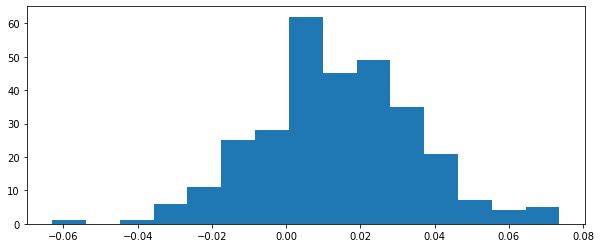

In [24]:
class_idx = 1
#score_list = memory_buffer.meta_score[class_idx, ..., 0]
# Remove the support = 0
score_list = memory_buffer.meta_score[class_idx,...,0][memory_buffer.meta_score[class_idx, ...,1] != 0]

fig, ax =  plt.subplots(figsize=(10,4))
ax.hist(score_list, bins=15)

### Plotting Distribution of Scores for one sample

#Scores in ScoreList 7
# Score in sample_idx: 0.020167368349738417
# Support in sample_idx: 7.0


(array([4., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1.]),
 array([0.01331691, 0.01507339, 0.01682986, 0.01858633, 0.0203428 ,
        0.02209927, 0.02385575, 0.02561222, 0.02736869, 0.02912516,
        0.03088163, 0.03263811, 0.03439458, 0.03615105, 0.03790752,
        0.03966399]),
 <BarContainer object of 15 artists>)

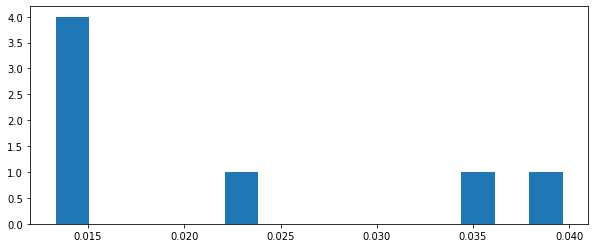

In [27]:
class_idx = 0
sample_idx = 0
score_list = memory_buffer.meta_debug[class_idx][sample_idx]

print(f"#Scores in ScoreList {len(score_list)}")
print(f"# Score in sample_idx: {memory_buffer.meta_score[class_idx, sample_idx, 0]}")
print(f"# Support in sample_idx: {memory_buffer.meta_score[class_idx, sample_idx, 1]}")

fig, ax =  plt.subplots(figsize=(10,4))
ax.hist(score_list, bins=15)

In [28]:
memory_buffer.meta_debug[class_idx].keys()

dict_keys([232, 69, 160, 127, 264, 244, 144, 93, 134, 298, 68, 216, 131, 26, 23, 154, 133, 253, 248, 63, 178, 86, 108, 92, 78, 158, 262, 243, 137, 188, 20, 79, 230, 94, 273, 6, 87, 155, 64, 8, 270, 283, 59, 10, 82, 224, 239, 184, 56, 259, 185, 255, 50, 62, 125, 228, 207, 275, 276, 145, 159, 14, 39, 265, 73, 258, 242, 60, 166, 202, 142, 287, 277, 96, 272, 165, 103, 162, 237, 174, 88, 211, 41, 90, 129, 22, 99, 115, 195, 5, 51, 168, 98, 181, 124, 238, 192, 58, 299, 101, 143, 107, 260, 247, 205, 141, 100, 97, 70, 116, 250, 13, 35, 122, 34, 111, 209, 226, 157, 193, 102, 46, 172, 85, 55, 257, 30, 77, 227, 139, 218, 156, 246, 296, 196, 256, 251, 3, 267, 189, 175, 1, 54, 170, 114, 132, 45, 91, 11, 49, 140, 222, 152, 32, 201, 153, 183, 281, 130, 233, 274, 190, 199, 206, 290, 136, 234, 117, 173, 291, 18, 16, 65, 67, 176, 148, 214, 146, 241, 57, 169, 292, 151, 245, 212, 171, 215, 120, 285, 112, 200, 27, 12, 118, 254, 37, 43, 74, 75, 53, 297, 240, 278, 66, 113, 186, 282, 150, 204, 84, 119, 163, 12

# Testing

Select specific column index per row
https://stackoverflow.com/questions/23435782/numpy-selecting-specific-column-index-per-row-by-using-a-list-of-indexes

In [29]:
def evaluate(dataloader, updates, mini_batch_size, dataname=""):
    learner.rln.eval()
    learner.pln.train()
    
    all_losses, all_predictions, all_labels, all_label_conf = [], [], [], []
    all_adaptation_time = []
    # Get Query set first. and then find supporting support set
    for query_idx, (query_text, query_labels) in enumerate(dataloader):
        print(f"Query ID {query_idx}/{len(dataloader)}")
        # The task id to optimize to for support set
        # task_idx = get_task_from_label_list(query_labels, memory_buffer.task_dict)
        task_idx = dataclass_mapper[dataname]
        
    
        support_set = []
        for _ in range(updates):
            text, labels = memory_buffer.read_batch_task(batch_size=mini_batch_size, task_idx=task_idx, sort_score=True)
            support_set.append((text, labels))

        with higher.innerloop_ctx(learner.pln, learner.inner_optimizer,
                                  copy_initial_weights=False, track_higher_grads=False) as (fpln, diffopt):
            
            INNER_tic = time.time()
            # Inner loop
            task_predictions, task_labels = [], []
            support_loss = []
            for text, labels in support_set:
                labels = torch.tensor(labels).to(device)
                input_dict = learner.rln.encode_text(text)
                _repr = learner.rln(input_dict)
                output = fpln(_repr)
                loss = learner.loss_fn(output, labels)
                diffopt.step(loss)
                pred = models.utils.make_prediction(output.detach())
                support_loss.append(loss.item())
                task_predictions.extend(pred.tolist())
                task_labels.extend(labels.tolist())
            INNER_toc = time.time() - INNER_tic
            all_adaptation_time.append(INNER_toc)

            acc, prec, rec, f1 = models.utils.calculate_metrics(task_predictions, task_labels)

            print('Support set metrics: Loss = {:.4f}, accuracy = {:.4f}, precision = {:.4f}, '
                        'recall = {:.4f}, F1 score = {:.4f}'.format(np.mean(support_loss), acc, prec, rec, f1))

            # Query set is now here!
            query_labels = torch.tensor(query_labels).to(device)
            query_input_dict = learner.rln.encode_text(query_text)
            with torch.no_grad():
                query_repr = learner.rln(query_input_dict)
                query_output = fpln(query_repr) # Output has size of torch.Size([16, 33]) [BATCH, CLASSES]
                query_loss = learner.loss_fn(query_output, query_labels)
            query_loss = query_loss.item()
            # print(output.detach().size())
            # output.detach().max(-1) max on each Batch, which will return [0] max, [1] indices
            query_output_softmax = F.softmax(query_output, -1)
            query_label_conf = query_output_softmax[np.arange(len(query_output_softmax)), query_labels] # Select labels in the softmax of 33 classes

            query_pred = models.utils.make_prediction(query_output.detach())
            query_acc, query_prec, query_rec, query_f1 = models.utils.calculate_metrics(query_pred.tolist(), query_labels.tolist())
            
            print('Query set metrics: Loss = {:.4f}, accuracy = {:.4f}, precision = {:.4f}, '
                'recall = {:.4f}, F1 score = {:.4f}'.format(np.mean(query_loss), query_acc, query_prec, query_rec, query_f1))

            all_losses.append(query_loss)
            all_predictions.extend(query_pred.tolist())
            all_labels.extend(query_labels.tolist())
            all_label_conf.extend(query_label_conf.tolist())

    acc, prec, rec, f1 = models.utils.calculate_metrics(all_predictions, all_labels)
    print('Test metrics: Loss = {:.4f}, accuracy = {:.4f}, precision = {:.4f}, recall = {:.4f}, '
                'F1 score = {:.4f}'.format(np.mean(all_losses), acc, prec, rec, f1))
    return acc, prec, rec, f1, all_predictions, all_labels, all_label_conf, all_adaptation_time

In [30]:
tic = time.time()
print('----------Testing on test set starts here----------')

accuracies, precisions, recalls, f1s = [], [], [], []
all_adapt_time = []
# Data for Visualization: [data_idx, label, label_conf, pred]
data_for_visual = []

for test_dataset in test_datasets:
    print('Testing on {}'.format(test_dataset.__class__.__name__))
    test_dataloader = data.DataLoader(test_dataset, batch_size=mini_batch_size, shuffle=False,
                                      collate_fn=datasets.utils.batch_encode)
    acc, prec, rec, f1, all_pred, all_label, all_label_conf, all_adaptation_time = evaluate(dataloader=test_dataloader, updates=updates, 
                                                mini_batch_size=mini_batch_size, dataname=test_dataset.__class__.__name__)
    
    data_ids = [test_dataset.__class__.__name__ + str(i) for i in range(len(all_label))]
    data_for_visual.extend(list(zip(data_ids, all_label, all_label_conf, all_pred)))
    all_adapt_time.extend(all_adaptation_time)
#     print(data_ids)
#     print(all_label)
#     raise Exception("BREAKPOINT")
    
    accuracies.append(acc)
    precisions.append(prec)
    recalls.append(rec)
    f1s.append(f1)


print()
print("COPY PASTA - not really but ok")
for row in accuracies:
    print(row)
print()
print('Overall test metrics: Accuracy = {:.4f}, precision = {:.4f}, recall = {:.4f}, '
            'F1 score = {:.4f}'.format(np.mean(accuracies), np.mean(precisions), np.mean(recalls), np.mean(f1s)))

toc = time.time() - tic
print(f"Total Time used: {toc//60} minutes")

----------Testing on test set starts here----------
Testing on YelpDataset
Query ID 0/475
Support set metrics: Loss = 1.0298, accuracy = 0.5000, precision = 0.5188, recall = 0.4800, F1 score = 0.4907
Query set metrics: Loss = 0.6001, accuracy = 0.7500, precision = 0.8867, recall = 0.7333, F1 score = 0.7318
Query ID 1/475
Support set metrics: Loss = 1.0640, accuracy = 0.4250, precision = 0.4863, recall = 0.4000, F1 score = 0.4242
Query set metrics: Loss = 0.6710, accuracy = 0.7500, precision = 0.7267, recall = 0.7933, F1 score = 0.7200
Query ID 2/475
Support set metrics: Loss = 0.9472, accuracy = 0.4875, precision = 0.4968, recall = 0.4667, F1 score = 0.4736
Query set metrics: Loss = 1.1433, accuracy = 0.5625, precision = 0.5124, recall = 0.5500, F1 score = 0.4883
Query ID 3/475
Support set metrics: Loss = 1.0854, accuracy = 0.3750, precision = 0.4105, recall = 0.3533, F1 score = 0.3546
Query set metrics: Loss = 0.9711, accuracy = 0.6875, precision = 0.7267, recall = 0.7000, F1 score = 

Support set metrics: Loss = 1.1194, accuracy = 0.3250, precision = 0.3794, recall = 0.3000, F1 score = 0.3318
Query set metrics: Loss = 0.7221, accuracy = 0.6250, precision = 0.5571, recall = 0.6375, F1 score = 0.5864
Query ID 36/475
Support set metrics: Loss = 1.0151, accuracy = 0.4625, precision = 0.5022, recall = 0.4367, F1 score = 0.4545
Query set metrics: Loss = 0.6912, accuracy = 0.6875, precision = 0.4267, recall = 0.5000, F1 score = 0.4587
Query ID 37/475
Support set metrics: Loss = 1.0060, accuracy = 0.4750, precision = 0.4755, recall = 0.4533, F1 score = 0.4510
Query set metrics: Loss = 0.8249, accuracy = 0.6250, precision = 0.6000, recall = 0.6600, F1 score = 0.6063
Query ID 38/475
Support set metrics: Loss = 1.0853, accuracy = 0.4125, precision = 0.4386, recall = 0.3900, F1 score = 0.4084
Query set metrics: Loss = 0.9466, accuracy = 0.5000, precision = 0.3733, recall = 0.5067, F1 score = 0.4087
Query ID 39/475
Support set metrics: Loss = 1.0530, accuracy = 0.4125, precision

Query set metrics: Loss = 1.5417, accuracy = 0.3125, precision = 0.4000, recall = 0.3467, F1 score = 0.2944
Query ID 71/475
Support set metrics: Loss = 0.9454, accuracy = 0.5000, precision = 0.5226, recall = 0.4800, F1 score = 0.4957
Query set metrics: Loss = 0.7915, accuracy = 0.6875, precision = 0.6433, recall = 0.5833, F1 score = 0.5944
Query ID 72/475
Support set metrics: Loss = 1.0333, accuracy = 0.4750, precision = 0.5115, recall = 0.4567, F1 score = 0.4754
Query set metrics: Loss = 0.8402, accuracy = 0.6875, precision = 0.7857, recall = 0.7900, F1 score = 0.7091
Query ID 73/475
Support set metrics: Loss = 1.1275, accuracy = 0.3750, precision = 0.4020, recall = 0.3433, F1 score = 0.3644
Query set metrics: Loss = 0.9679, accuracy = 0.6875, precision = 0.6033, recall = 0.6033, F1 score = 0.5881
Query ID 74/475
Support set metrics: Loss = 0.9865, accuracy = 0.5125, precision = 0.5292, recall = 0.4833, F1 score = 0.4798
Query set metrics: Loss = 0.9540, accuracy = 0.4375, precision =

Query set metrics: Loss = 0.6651, accuracy = 0.6875, precision = 0.6600, recall = 0.6500, F1 score = 0.6492
Query ID 106/475
Support set metrics: Loss = 1.1503, accuracy = 0.3625, precision = 0.4047, recall = 0.3433, F1 score = 0.3679
Query set metrics: Loss = 1.2535, accuracy = 0.4375, precision = 0.3833, recall = 0.5333, F1 score = 0.4127
Query ID 107/475
Support set metrics: Loss = 1.1168, accuracy = 0.3750, precision = 0.4216, recall = 0.3533, F1 score = 0.3729
Query set metrics: Loss = 0.8597, accuracy = 0.6875, precision = 0.6333, recall = 0.6167, F1 score = 0.6057
Query ID 108/475
Support set metrics: Loss = 1.0594, accuracy = 0.4250, precision = 0.4485, recall = 0.4067, F1 score = 0.4196
Query set metrics: Loss = 1.2116, accuracy = 0.3125, precision = 0.2333, recall = 0.2800, F1 score = 0.2333
Query ID 109/475
Support set metrics: Loss = 1.0903, accuracy = 0.4000, precision = 0.4404, recall = 0.3833, F1 score = 0.4057
Query set metrics: Loss = 1.1667, accuracy = 0.3750, precisi

Query set metrics: Loss = 0.5951, accuracy = 0.8750, precision = 0.9200, recall = 0.9200, F1 score = 0.9000
Query ID 141/475
Support set metrics: Loss = 1.0944, accuracy = 0.4250, precision = 0.4397, recall = 0.4000, F1 score = 0.4068
Query set metrics: Loss = 0.7875, accuracy = 0.6875, precision = 0.5300, recall = 0.6000, F1 score = 0.5611
Query ID 142/475
Support set metrics: Loss = 1.1311, accuracy = 0.4125, precision = 0.4273, recall = 0.3900, F1 score = 0.3984
Query set metrics: Loss = 0.8606, accuracy = 0.6250, precision = 0.6833, recall = 0.6300, F1 score = 0.6243
Query ID 143/475
Support set metrics: Loss = 1.0271, accuracy = 0.4500, precision = 0.4945, recall = 0.4200, F1 score = 0.4281
Query set metrics: Loss = 0.5533, accuracy = 0.8750, precision = 0.8667, recall = 0.9000, F1 score = 0.8533
Query ID 144/475
Support set metrics: Loss = 1.0555, accuracy = 0.3875, precision = 0.4376, recall = 0.3700, F1 score = 0.3907
Query set metrics: Loss = 1.0151, accuracy = 0.5625, precisi

Query set metrics: Loss = 0.9725, accuracy = 0.5000, precision = 0.4833, recall = 0.5133, F1 score = 0.4476
Query ID 176/475
Support set metrics: Loss = 1.0172, accuracy = 0.4750, precision = 0.5025, recall = 0.4500, F1 score = 0.4693
Query set metrics: Loss = 0.9774, accuracy = 0.6250, precision = 0.6333, recall = 0.6333, F1 score = 0.6167
Query ID 177/475
Support set metrics: Loss = 1.0870, accuracy = 0.3875, precision = 0.3979, recall = 0.3700, F1 score = 0.3743
Query set metrics: Loss = 0.6321, accuracy = 0.6250, precision = 0.7917, recall = 0.7333, F1 score = 0.6792
Query ID 178/475
Support set metrics: Loss = 1.0730, accuracy = 0.3875, precision = 0.3889, recall = 0.3567, F1 score = 0.3698
Query set metrics: Loss = 1.2852, accuracy = 0.4375, precision = 0.4200, recall = 0.4700, F1 score = 0.4400
Query ID 179/475
Support set metrics: Loss = 1.0862, accuracy = 0.4000, precision = 0.4319, recall = 0.3867, F1 score = 0.3985
Query set metrics: Loss = 0.9668, accuracy = 0.4375, precisi

Query set metrics: Loss = 1.0634, accuracy = 0.5000, precision = 0.3267, recall = 0.5000, F1 score = 0.3911
Query ID 211/475
Support set metrics: Loss = 1.0333, accuracy = 0.4875, precision = 0.5150, recall = 0.4700, F1 score = 0.4790
Query set metrics: Loss = 1.0272, accuracy = 0.5000, precision = 0.4500, recall = 0.5833, F1 score = 0.4400
Query ID 212/475
Support set metrics: Loss = 1.0310, accuracy = 0.4375, precision = 0.4422, recall = 0.4200, F1 score = 0.4178
Query set metrics: Loss = 0.8276, accuracy = 0.6875, precision = 0.6800, recall = 0.7000, F1 score = 0.6778
Query ID 213/475
Support set metrics: Loss = 1.0167, accuracy = 0.4000, precision = 0.4303, recall = 0.3867, F1 score = 0.4010
Query set metrics: Loss = 0.8022, accuracy = 0.6250, precision = 0.5400, recall = 0.4667, F1 score = 0.4705
Query ID 214/475
Support set metrics: Loss = 1.0768, accuracy = 0.4500, precision = 0.4876, recall = 0.4200, F1 score = 0.4246
Query set metrics: Loss = 1.2905, accuracy = 0.3750, precisi

Support set metrics: Loss = 0.9998, accuracy = 0.4625, precision = 0.4383, recall = 0.4433, F1 score = 0.4185
Query set metrics: Loss = 0.8719, accuracy = 0.6250, precision = 0.5333, recall = 0.6000, F1 score = 0.5390
Query ID 247/475
Support set metrics: Loss = 1.0591, accuracy = 0.4250, precision = 0.4342, recall = 0.4100, F1 score = 0.4160
Query set metrics: Loss = 1.2587, accuracy = 0.6875, precision = 0.8000, recall = 0.7300, F1 score = 0.6952
Query ID 248/475
Support set metrics: Loss = 0.9888, accuracy = 0.4375, precision = 0.4653, recall = 0.4133, F1 score = 0.4170
Query set metrics: Loss = 0.8376, accuracy = 0.5625, precision = 0.6000, recall = 0.6000, F1 score = 0.5810
Query ID 249/475
Support set metrics: Loss = 1.0379, accuracy = 0.4875, precision = 0.5187, recall = 0.4667, F1 score = 0.4845
Query set metrics: Loss = 1.0053, accuracy = 0.5000, precision = 0.6200, recall = 0.6690, F1 score = 0.5978
Query ID 250/475
Support set metrics: Loss = 0.9657, accuracy = 0.4875, preci

Query ID 281/475
Support set metrics: Loss = 1.1102, accuracy = 0.3750, precision = 0.3975, recall = 0.3433, F1 score = 0.3481
Query set metrics: Loss = 0.8941, accuracy = 0.5625, precision = 0.5667, recall = 0.7200, F1 score = 0.5794
Query ID 282/475
Support set metrics: Loss = 1.0560, accuracy = 0.4375, precision = 0.4446, recall = 0.4167, F1 score = 0.4200
Query set metrics: Loss = 0.9298, accuracy = 0.6875, precision = 0.7200, recall = 0.7500, F1 score = 0.7214
Query ID 283/475
Support set metrics: Loss = 1.0552, accuracy = 0.4750, precision = 0.4765, recall = 0.4567, F1 score = 0.4596
Query set metrics: Loss = 1.1191, accuracy = 0.6250, precision = 0.6476, recall = 0.6167, F1 score = 0.6055
Query ID 284/475
Support set metrics: Loss = 0.9747, accuracy = 0.4750, precision = 0.4902, recall = 0.4633, F1 score = 0.4652
Query set metrics: Loss = 0.6799, accuracy = 0.7500, precision = 0.7333, recall = 0.8095, F1 score = 0.7538
Query ID 285/475
Support set metrics: Loss = 1.0632, accurac

Support set metrics: Loss = 1.0640, accuracy = 0.3750, precision = 0.3484, recall = 0.3467, F1 score = 0.3337
Query set metrics: Loss = 0.6942, accuracy = 0.6250, precision = 0.5800, recall = 0.6167, F1 score = 0.5610
Query ID 317/475
Support set metrics: Loss = 1.0093, accuracy = 0.5000, precision = 0.4736, recall = 0.4767, F1 score = 0.4687
Query set metrics: Loss = 0.8675, accuracy = 0.5000, precision = 0.2717, recall = 0.4000, F1 score = 0.3205
Query ID 318/475
Support set metrics: Loss = 1.0398, accuracy = 0.3875, precision = 0.4187, recall = 0.3600, F1 score = 0.3664
Query set metrics: Loss = 1.0606, accuracy = 0.6250, precision = 0.6700, recall = 0.6500, F1 score = 0.6414
Query ID 319/475
Support set metrics: Loss = 1.0844, accuracy = 0.4125, precision = 0.4372, recall = 0.3900, F1 score = 0.4030
Query set metrics: Loss = 1.0560, accuracy = 0.6250, precision = 0.5500, recall = 0.6500, F1 score = 0.5762
Query ID 320/475
Support set metrics: Loss = 1.1200, accuracy = 0.3875, preci

Support set metrics: Loss = 1.0038, accuracy = 0.3625, precision = 0.4130, recall = 0.3467, F1 score = 0.3725
Query set metrics: Loss = 1.4190, accuracy = 0.6250, precision = 0.6500, recall = 0.6190, F1 score = 0.6024
Query ID 352/475
Support set metrics: Loss = 1.0978, accuracy = 0.4250, precision = 0.4512, recall = 0.3967, F1 score = 0.4044
Query set metrics: Loss = 0.6864, accuracy = 0.8750, precision = 0.8750, recall = 0.9000, F1 score = 0.8533
Query ID 353/475
Support set metrics: Loss = 1.0346, accuracy = 0.5125, precision = 0.5284, recall = 0.4900, F1 score = 0.5002
Query set metrics: Loss = 1.2920, accuracy = 0.2500, precision = 0.2500, recall = 0.1667, F1 score = 0.2000
Query ID 354/475
Support set metrics: Loss = 1.0313, accuracy = 0.4500, precision = 0.4544, recall = 0.4300, F1 score = 0.4249
Query set metrics: Loss = 0.9781, accuracy = 0.6250, precision = 0.5767, recall = 0.6700, F1 score = 0.5778
Query ID 355/475
Support set metrics: Loss = 1.0154, accuracy = 0.4375, preci

Support set metrics: Loss = 1.0011, accuracy = 0.4500, precision = 0.5236, recall = 0.4333, F1 score = 0.4667
Query set metrics: Loss = 1.0291, accuracy = 0.4375, precision = 0.5167, recall = 0.4133, F1 score = 0.4324
Query ID 387/475
Support set metrics: Loss = 1.0334, accuracy = 0.4125, precision = 0.4593, recall = 0.3867, F1 score = 0.4127
Query set metrics: Loss = 1.4707, accuracy = 0.4375, precision = 0.5167, recall = 0.4238, F1 score = 0.4270
Query ID 388/475
Support set metrics: Loss = 0.9990, accuracy = 0.4500, precision = 0.4636, recall = 0.4267, F1 score = 0.4332
Query set metrics: Loss = 0.6890, accuracy = 0.7500, precision = 0.8400, recall = 0.7833, F1 score = 0.7321
Query ID 389/475
Support set metrics: Loss = 1.0281, accuracy = 0.4500, precision = 0.4964, recall = 0.4267, F1 score = 0.4517
Query set metrics: Loss = 1.1433, accuracy = 0.5625, precision = 0.5600, recall = 0.6000, F1 score = 0.4833
Query ID 390/475
Support set metrics: Loss = 1.0134, accuracy = 0.4625, preci

Support set metrics: Loss = 1.0164, accuracy = 0.4625, precision = 0.5039, recall = 0.4400, F1 score = 0.4613
Query set metrics: Loss = 1.2989, accuracy = 0.3750, precision = 0.2867, recall = 0.3786, F1 score = 0.2778
Query ID 422/475
Support set metrics: Loss = 1.0696, accuracy = 0.4125, precision = 0.4430, recall = 0.3933, F1 score = 0.4111
Query set metrics: Loss = 1.2799, accuracy = 0.6250, precision = 0.7167, recall = 0.7200, F1 score = 0.7105
Query ID 423/475
Support set metrics: Loss = 1.0831, accuracy = 0.3875, precision = 0.4393, recall = 0.3633, F1 score = 0.3932
Query set metrics: Loss = 0.9682, accuracy = 0.5625, precision = 0.5667, recall = 0.6167, F1 score = 0.5733
Query ID 424/475
Support set metrics: Loss = 1.0237, accuracy = 0.4625, precision = 0.4403, recall = 0.4433, F1 score = 0.4288
Query set metrics: Loss = 1.0508, accuracy = 0.5000, precision = 0.5750, recall = 0.5625, F1 score = 0.5458
Query ID 425/475
Support set metrics: Loss = 1.0363, accuracy = 0.4500, preci

Support set metrics: Loss = 1.0641, accuracy = 0.4375, precision = 0.4547, recall = 0.4167, F1 score = 0.4213
Query set metrics: Loss = 1.1702, accuracy = 0.6250, precision = 0.7000, recall = 0.5933, F1 score = 0.6378
Query ID 457/475
Support set metrics: Loss = 1.0280, accuracy = 0.4125, precision = 0.4355, recall = 0.3900, F1 score = 0.4037
Query set metrics: Loss = 0.5791, accuracy = 0.8125, precision = 0.8700, recall = 0.8500, F1 score = 0.8429
Query ID 458/475
Support set metrics: Loss = 1.0374, accuracy = 0.4125, precision = 0.4319, recall = 0.3933, F1 score = 0.3978
Query set metrics: Loss = 1.0974, accuracy = 0.7500, precision = 0.5981, recall = 0.7314, F1 score = 0.6314
Query ID 459/475
Support set metrics: Loss = 1.0403, accuracy = 0.4750, precision = 0.4927, recall = 0.4433, F1 score = 0.4386
Query set metrics: Loss = 0.7792, accuracy = 0.5000, precision = 0.4533, recall = 0.6667, F1 score = 0.4500
Query ID 460/475
Support set metrics: Loss = 1.0666, accuracy = 0.5000, preci

Support set metrics: Loss = 1.0438, accuracy = 0.4375, precision = 0.4238, recall = 0.4375, F1 score = 0.4284
Query set metrics: Loss = 0.0635, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 17/475
Support set metrics: Loss = 1.0243, accuracy = 0.4625, precision = 0.4660, recall = 0.4625, F1 score = 0.4613
Query set metrics: Loss = 0.3578, accuracy = 0.8750, precision = 0.8875, recall = 0.8750, F1 score = 0.8740
Query ID 18/475
Support set metrics: Loss = 1.0613, accuracy = 0.3625, precision = 0.3533, recall = 0.3625, F1 score = 0.3564
Query set metrics: Loss = 0.3463, accuracy = 0.8750, precision = 0.9083, recall = 0.9083, F1 score = 0.9083
Query ID 19/475
Support set metrics: Loss = 1.0549, accuracy = 0.4000, precision = 0.4044, recall = 0.4000, F1 score = 0.4019
Query set metrics: Loss = 0.6786, accuracy = 0.8125, precision = 0.8333, recall = 0.8021, F1 score = 0.7333
Query ID 20/475
Support set metrics: Loss = 0.8940, accuracy = 0.4875, precision

Support set metrics: Loss = 1.2220, accuracy = 0.3500, precision = 0.3686, recall = 0.3500, F1 score = 0.3574
Query set metrics: Loss = 0.2155, accuracy = 0.9375, precision = 0.9375, recall = 0.9500, F1 score = 0.9365
Query ID 53/475
Support set metrics: Loss = 1.0290, accuracy = 0.4625, precision = 0.4778, recall = 0.4625, F1 score = 0.4691
Query set metrics: Loss = 0.0744, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 54/475
Support set metrics: Loss = 1.0623, accuracy = 0.4000, precision = 0.4432, recall = 0.4000, F1 score = 0.4190
Query set metrics: Loss = 0.3064, accuracy = 0.8125, precision = 0.5750, recall = 0.6167, F1 score = 0.5929
Query ID 55/475
Support set metrics: Loss = 0.8970, accuracy = 0.4625, precision = 0.4643, recall = 0.4625, F1 score = 0.4577
Query set metrics: Loss = 0.0676, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 56/475
Support set metrics: Loss = 0.9362, accuracy = 0.4500, precision

Support set metrics: Loss = 1.0881, accuracy = 0.3750, precision = 0.3715, recall = 0.3750, F1 score = 0.3681
Query set metrics: Loss = 0.3432, accuracy = 0.9375, precision = 0.8750, recall = 0.9500, F1 score = 0.8889
Query ID 89/475
Support set metrics: Loss = 1.0580, accuracy = 0.3875, precision = 0.4066, recall = 0.3875, F1 score = 0.3950
Query set metrics: Loss = 0.0810, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 90/475
Support set metrics: Loss = 1.0234, accuracy = 0.4000, precision = 0.3935, recall = 0.4000, F1 score = 0.3959
Query set metrics: Loss = 0.1751, accuracy = 0.9375, precision = 0.9375, recall = 0.9375, F1 score = 0.9286
Query ID 91/475
Support set metrics: Loss = 1.0299, accuracy = 0.4500, precision = 0.4353, recall = 0.4500, F1 score = 0.4386
Query set metrics: Loss = 0.1006, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 92/475
Support set metrics: Loss = 1.1269, accuracy = 0.3875, precision

Support set metrics: Loss = 1.1940, accuracy = 0.3250, precision = 0.3152, recall = 0.3250, F1 score = 0.3194
Query set metrics: Loss = 0.0769, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 124/475
Support set metrics: Loss = 0.9419, accuracy = 0.4125, precision = 0.3759, recall = 0.4125, F1 score = 0.3923
Query set metrics: Loss = 0.2168, accuracy = 0.9375, precision = 0.9643, recall = 0.9167, F1 score = 0.9308
Query ID 125/475
Support set metrics: Loss = 0.9049, accuracy = 0.5000, precision = 0.4695, recall = 0.5000, F1 score = 0.4801
Query set metrics: Loss = 0.5445, accuracy = 0.8125, precision = 0.9250, recall = 0.8125, F1 score = 0.8368
Query ID 126/475
Support set metrics: Loss = 1.1467, accuracy = 0.3750, precision = 0.3624, recall = 0.3750, F1 score = 0.3670
Query set metrics: Loss = 0.2413, accuracy = 0.8750, precision = 0.8667, recall = 0.8667, F1 score = 0.8667
Query ID 127/475
Support set metrics: Loss = 0.9672, accuracy = 0.4125, preci

Support set metrics: Loss = 0.9424, accuracy = 0.4000, precision = 0.3820, recall = 0.4000, F1 score = 0.3901
Query set metrics: Loss = 0.1940, accuracy = 0.8750, precision = 0.8750, recall = 0.8750, F1 score = 0.8750
Query ID 159/475
Support set metrics: Loss = 0.9965, accuracy = 0.4500, precision = 0.4376, recall = 0.4500, F1 score = 0.4421
Query set metrics: Loss = 0.0679, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 160/475
Support set metrics: Loss = 1.1403, accuracy = 0.3125, precision = 0.3194, recall = 0.3125, F1 score = 0.3155
Query set metrics: Loss = 0.2739, accuracy = 0.8750, precision = 0.8333, recall = 0.9167, F1 score = 0.8250
Query ID 161/475
Support set metrics: Loss = 0.9994, accuracy = 0.5000, precision = 0.4799, recall = 0.5000, F1 score = 0.4869
Query set metrics: Loss = 0.2840, accuracy = 0.8750, precision = 0.9286, recall = 0.8810, F1 score = 0.8891
Query ID 162/475
Support set metrics: Loss = 0.9507, accuracy = 0.4875, preci

Support set metrics: Loss = 1.0036, accuracy = 0.4375, precision = 0.4326, recall = 0.4375, F1 score = 0.4329
Query set metrics: Loss = 0.1591, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 194/475
Support set metrics: Loss = 1.0347, accuracy = 0.4000, precision = 0.4046, recall = 0.4000, F1 score = 0.3999
Query set metrics: Loss = 0.0697, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 195/475
Support set metrics: Loss = 1.0763, accuracy = 0.3500, precision = 0.3455, recall = 0.3500, F1 score = 0.3466
Query set metrics: Loss = 0.2355, accuracy = 0.9375, precision = 0.9167, recall = 0.9500, F1 score = 0.9222
Query ID 196/475
Support set metrics: Loss = 1.0359, accuracy = 0.4125, precision = 0.4073, recall = 0.4125, F1 score = 0.4088
Query set metrics: Loss = 0.0576, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 197/475
Support set metrics: Loss = 0.8381, accuracy = 0.5125, preci

Support set metrics: Loss = 1.1153, accuracy = 0.3750, precision = 0.3849, recall = 0.3750, F1 score = 0.3798
Query set metrics: Loss = 0.0865, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 229/475
Support set metrics: Loss = 1.0417, accuracy = 0.3750, precision = 0.3559, recall = 0.3750, F1 score = 0.3639
Query set metrics: Loss = 0.0359, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 230/475
Support set metrics: Loss = 1.0436, accuracy = 0.4375, precision = 0.4227, recall = 0.4375, F1 score = 0.4269
Query set metrics: Loss = 0.1909, accuracy = 0.9375, precision = 0.9500, recall = 0.9500, F1 score = 0.9444
Query ID 231/475
Support set metrics: Loss = 0.9853, accuracy = 0.4375, precision = 0.4182, recall = 0.4375, F1 score = 0.4249
Query set metrics: Loss = 0.1840, accuracy = 0.9375, precision = 0.9500, recall = 0.9643, F1 score = 0.9530
Query ID 232/475
Support set metrics: Loss = 1.0093, accuracy = 0.4750, preci

Support set metrics: Loss = 0.9797, accuracy = 0.4625, precision = 0.4417, recall = 0.4625, F1 score = 0.4473
Query set metrics: Loss = 0.2080, accuracy = 0.9375, precision = 0.9583, recall = 0.9167, F1 score = 0.9273
Query ID 264/475
Support set metrics: Loss = 1.0989, accuracy = 0.4125, precision = 0.4099, recall = 0.4125, F1 score = 0.4091
Query set metrics: Loss = 0.1887, accuracy = 0.8750, precision = 0.8750, recall = 0.8810, F1 score = 0.8474
Query ID 265/475
Support set metrics: Loss = 0.9947, accuracy = 0.4250, precision = 0.4108, recall = 0.4250, F1 score = 0.4157
Query set metrics: Loss = 0.2703, accuracy = 0.9375, precision = 0.9375, recall = 0.9500, F1 score = 0.9365
Query ID 266/475
Support set metrics: Loss = 1.0261, accuracy = 0.3750, precision = 0.3548, recall = 0.3750, F1 score = 0.3627
Query set metrics: Loss = 0.4393, accuracy = 0.8125, precision = 0.8542, recall = 0.8375, F1 score = 0.8415
Query ID 267/475
Support set metrics: Loss = 1.0086, accuracy = 0.4375, preci

Support set metrics: Loss = 1.0891, accuracy = 0.3875, precision = 0.3845, recall = 0.3875, F1 score = 0.3857
Query set metrics: Loss = 0.2952, accuracy = 0.8750, precision = 0.6518, recall = 0.7143, F1 score = 0.6786
Query ID 299/475
Support set metrics: Loss = 1.0166, accuracy = 0.3375, precision = 0.3233, recall = 0.3375, F1 score = 0.3292
Query set metrics: Loss = 0.1661, accuracy = 0.8750, precision = 0.8958, recall = 0.8958, F1 score = 0.8958
Query ID 300/475
Support set metrics: Loss = 1.0159, accuracy = 0.4250, precision = 0.4271, recall = 0.4250, F1 score = 0.4257
Query set metrics: Loss = 0.3272, accuracy = 0.8750, precision = 0.8854, recall = 0.8333, F1 score = 0.8500
Query ID 301/475
Support set metrics: Loss = 1.0455, accuracy = 0.4000, precision = 0.4488, recall = 0.4000, F1 score = 0.4214
Query set metrics: Loss = 0.1465, accuracy = 0.9375, precision = 0.9167, recall = 0.9500, F1 score = 0.9222
Query ID 302/475
Support set metrics: Loss = 1.1997, accuracy = 0.3500, preci

Support set metrics: Loss = 0.9290, accuracy = 0.4875, precision = 0.4665, recall = 0.4875, F1 score = 0.4730
Query set metrics: Loss = 0.1683, accuracy = 0.9375, precision = 0.9375, recall = 0.9500, F1 score = 0.9365
Query ID 334/475
Support set metrics: Loss = 1.0480, accuracy = 0.3125, precision = 0.2722, recall = 0.3125, F1 score = 0.2906
Query set metrics: Loss = 0.1485, accuracy = 0.9375, precision = 0.9500, recall = 0.9500, F1 score = 0.9444
Query ID 335/475
Support set metrics: Loss = 1.0679, accuracy = 0.4125, precision = 0.4130, recall = 0.4125, F1 score = 0.4087
Query set metrics: Loss = 0.5021, accuracy = 0.8125, precision = 0.7893, recall = 0.8310, F1 score = 0.7810
Query ID 336/475
Support set metrics: Loss = 1.0822, accuracy = 0.4625, precision = 0.4673, recall = 0.4625, F1 score = 0.4645
Query set metrics: Loss = 0.4778, accuracy = 0.8750, precision = 0.8854, recall = 0.8438, F1 score = 0.8354
Query ID 337/475
Support set metrics: Loss = 0.9509, accuracy = 0.4500, preci

Support set metrics: Loss = 0.9700, accuracy = 0.5000, precision = 0.4788, recall = 0.5000, F1 score = 0.4858
Query set metrics: Loss = 0.2763, accuracy = 0.9375, precision = 0.9583, recall = 0.8750, F1 score = 0.8939
Query ID 369/475
Support set metrics: Loss = 0.9039, accuracy = 0.5000, precision = 0.4838, recall = 0.5000, F1 score = 0.4887
Query set metrics: Loss = 0.1623, accuracy = 0.9375, precision = 0.9167, recall = 0.9583, F1 score = 0.9273
Query ID 370/475
Support set metrics: Loss = 1.0314, accuracy = 0.4000, precision = 0.3839, recall = 0.4000, F1 score = 0.3905
Query set metrics: Loss = 0.0420, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 371/475
Support set metrics: Loss = 1.2079, accuracy = 0.3125, precision = 0.3012, recall = 0.3125, F1 score = 0.3061
Query set metrics: Loss = 0.6485, accuracy = 0.7500, precision = 0.7810, recall = 0.6935, F1 score = 0.7143
Query ID 372/475
Support set metrics: Loss = 1.0211, accuracy = 0.3875, preci

Support set metrics: Loss = 1.0882, accuracy = 0.4000, precision = 0.4064, recall = 0.4000, F1 score = 0.4027
Query set metrics: Loss = 0.4848, accuracy = 0.8125, precision = 0.9000, recall = 0.8375, F1 score = 0.8542
Query ID 404/475
Support set metrics: Loss = 0.9739, accuracy = 0.5000, precision = 0.5098, recall = 0.5000, F1 score = 0.5021
Query set metrics: Loss = 0.2539, accuracy = 0.8750, precision = 0.9375, recall = 0.9000, F1 score = 0.9018
Query ID 405/475
Support set metrics: Loss = 0.9821, accuracy = 0.4500, precision = 0.4601, recall = 0.4500, F1 score = 0.4532
Query set metrics: Loss = 0.1094, accuracy = 0.9375, precision = 1.0000, recall = 0.8333, F1 score = 0.8889
Query ID 406/475
Support set metrics: Loss = 1.0192, accuracy = 0.3375, precision = 0.3254, recall = 0.3375, F1 score = 0.3302
Query set metrics: Loss = 1.0439, accuracy = 0.6250, precision = 0.6500, recall = 0.6667, F1 score = 0.5958
Query ID 407/475
Support set metrics: Loss = 1.0629, accuracy = 0.4125, preci

Support set metrics: Loss = 1.0706, accuracy = 0.4250, precision = 0.4139, recall = 0.4250, F1 score = 0.4181
Query set metrics: Loss = 0.1288, accuracy = 0.9375, precision = 0.9375, recall = 0.9500, F1 score = 0.9365
Query ID 439/475
Support set metrics: Loss = 1.0601, accuracy = 0.4125, precision = 0.4310, recall = 0.4125, F1 score = 0.4208
Query set metrics: Loss = 0.4029, accuracy = 0.8750, precision = 0.8250, recall = 0.8250, F1 score = 0.8250
Query ID 440/475
Support set metrics: Loss = 1.1296, accuracy = 0.4000, precision = 0.4105, recall = 0.4000, F1 score = 0.4048
Query set metrics: Loss = 0.1900, accuracy = 0.9375, precision = 0.9167, recall = 0.9500, F1 score = 0.9222
Query ID 441/475
Support set metrics: Loss = 1.1239, accuracy = 0.3500, precision = 0.3473, recall = 0.3500, F1 score = 0.3481
Query set metrics: Loss = 0.1310, accuracy = 0.9375, precision = 0.9375, recall = 0.9500, F1 score = 0.9365
Query ID 442/475
Support set metrics: Loss = 1.0890, accuracy = 0.4500, preci

Support set metrics: Loss = 0.8997, accuracy = 0.4375, precision = 0.4014, recall = 0.4375, F1 score = 0.4141
Query set metrics: Loss = 0.0703, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 474/475
Support set metrics: Loss = 0.9356, accuracy = 0.5250, precision = 0.5207, recall = 0.5250, F1 score = 0.5214
Query set metrics: Loss = 0.0638, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Test metrics: Loss = 0.2592, accuracy = 0.9145, precision = 0.9190, recall = 0.9145, F1 score = 0.9158
Testing on DBPediaDataset
Query ID 0/475
Support set metrics: Loss = 0.3660, accuracy = 0.9125, precision = 0.9286, recall = 0.9357, F1 score = 0.9235
Query set metrics: Loss = 0.0052, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 1/475
Support set metrics: Loss = 0.3684, accuracy = 0.7875, precision = 0.8478, recall = 0.8143, F1 score = 0.8191
Query set metrics: Loss = 0.0055, accuracy = 1.0000, precisi

Support set metrics: Loss = 0.3758, accuracy = 0.8375, precision = 0.8904, recall = 0.8786, F1 score = 0.8723
Query set metrics: Loss = 0.0114, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 34/475
Support set metrics: Loss = 0.4407, accuracy = 0.8625, precision = 0.9171, recall = 0.8857, F1 score = 0.8861
Query set metrics: Loss = 0.0049, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 35/475
Support set metrics: Loss = 0.8649, accuracy = 0.7750, precision = 0.8452, recall = 0.8214, F1 score = 0.8163
Query set metrics: Loss = 0.0207, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 36/475
Support set metrics: Loss = 0.4765, accuracy = 0.8500, precision = 0.8815, recall = 0.8643, F1 score = 0.8565
Query set metrics: Loss = 0.4708, accuracy = 0.9375, precision = 0.9500, recall = 0.9500, F1 score = 0.9333
Query ID 37/475
Support set metrics: Loss = 0.4850, accuracy = 0.8500, precision

Support set metrics: Loss = 0.4280, accuracy = 0.8375, precision = 0.8839, recall = 0.8714, F1 score = 0.8626
Query set metrics: Loss = 0.0060, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 70/475
Support set metrics: Loss = 0.6196, accuracy = 0.7750, precision = 0.8516, recall = 0.8071, F1 score = 0.8110
Query set metrics: Loss = 0.4711, accuracy = 0.9375, precision = 0.8889, recall = 0.8889, F1 score = 0.8889
Query ID 71/475
Support set metrics: Loss = 0.2805, accuracy = 0.8875, precision = 0.9218, recall = 0.9000, F1 score = 0.9044
Query set metrics: Loss = 0.0524, accuracy = 0.9375, precision = 0.9630, recall = 0.9630, F1 score = 0.9556
Query ID 72/475
Support set metrics: Loss = 0.2306, accuracy = 0.8875, precision = 0.9127, recall = 0.9000, F1 score = 0.8961
Query set metrics: Loss = 0.0045, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 73/475
Support set metrics: Loss = 0.2073, accuracy = 0.9500, precision

Support set metrics: Loss = 0.3798, accuracy = 0.8375, precision = 0.8933, recall = 0.8643, F1 score = 0.8615
Query set metrics: Loss = 0.0092, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 105/475
Support set metrics: Loss = 0.4037, accuracy = 0.9000, precision = 0.9306, recall = 0.9214, F1 score = 0.9222
Query set metrics: Loss = 0.0073, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 106/475
Support set metrics: Loss = 0.6009, accuracy = 0.8125, precision = 0.8512, recall = 0.8429, F1 score = 0.8358
Query set metrics: Loss = 0.1969, accuracy = 0.9375, precision = 0.9500, recall = 0.9800, F1 score = 0.9556
Query ID 107/475
Support set metrics: Loss = 0.2296, accuracy = 0.9000, precision = 0.9137, recall = 0.9143, F1 score = 0.9111
Query set metrics: Loss = 0.0545, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 108/475
Support set metrics: Loss = 0.4352, accuracy = 0.8750, preci

Support set metrics: Loss = 0.5088, accuracy = 0.8500, precision = 0.8840, recall = 0.8714, F1 score = 0.8667
Query set metrics: Loss = 0.0217, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 140/475
Support set metrics: Loss = 0.5737, accuracy = 0.8375, precision = 0.8746, recall = 0.8643, F1 score = 0.8571
Query set metrics: Loss = 0.0511, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 141/475
Support set metrics: Loss = 0.3674, accuracy = 0.8750, precision = 0.9184, recall = 0.9000, F1 score = 0.8932
Query set metrics: Loss = 0.0104, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 142/475
Support set metrics: Loss = 0.3779, accuracy = 0.8375, precision = 0.8887, recall = 0.8429, F1 score = 0.8524
Query set metrics: Loss = 0.0061, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 143/475
Support set metrics: Loss = 0.4308, accuracy = 0.8750, preci

Support set metrics: Loss = 0.4130, accuracy = 0.8625, precision = 0.9054, recall = 0.9000, F1 score = 0.8975
Query set metrics: Loss = 0.0047, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 175/475
Support set metrics: Loss = 0.4950, accuracy = 0.8375, precision = 0.8815, recall = 0.8714, F1 score = 0.8617
Query set metrics: Loss = 0.0052, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 176/475
Support set metrics: Loss = 0.5108, accuracy = 0.8750, precision = 0.9161, recall = 0.9000, F1 score = 0.8965
Query set metrics: Loss = 0.0265, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 177/475
Support set metrics: Loss = 0.4437, accuracy = 0.8875, precision = 0.9167, recall = 0.9000, F1 score = 0.9033
Query set metrics: Loss = 0.0052, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 178/475
Support set metrics: Loss = 0.5507, accuracy = 0.8500, preci

Support set metrics: Loss = 0.4618, accuracy = 0.7875, precision = 0.8639, recall = 0.8071, F1 score = 0.8240
Query set metrics: Loss = 0.0043, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 210/475
Support set metrics: Loss = 0.4491, accuracy = 0.8375, precision = 0.8845, recall = 0.8643, F1 score = 0.8616
Query set metrics: Loss = 0.0039, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 211/475
Support set metrics: Loss = 0.4004, accuracy = 0.8750, precision = 0.8946, recall = 0.9000, F1 score = 0.8917
Query set metrics: Loss = 0.1614, accuracy = 0.9375, precision = 0.8636, recall = 0.9091, F1 score = 0.8788
Query ID 212/475
Support set metrics: Loss = 0.3453, accuracy = 0.8750, precision = 0.9034, recall = 0.8929, F1 score = 0.8902
Query set metrics: Loss = 0.0062, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 213/475
Support set metrics: Loss = 0.3022, accuracy = 0.8500, preci

Support set metrics: Loss = 0.6319, accuracy = 0.7875, precision = 0.8450, recall = 0.8286, F1 score = 0.8258
Query set metrics: Loss = 0.3452, accuracy = 0.9375, precision = 0.9545, recall = 0.9773, F1 score = 0.9567
Query ID 245/475
Support set metrics: Loss = 0.4478, accuracy = 0.8375, precision = 0.8768, recall = 0.8786, F1 score = 0.8673
Query set metrics: Loss = 0.0053, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 246/475
Support set metrics: Loss = 0.5632, accuracy = 0.8500, precision = 0.8773, recall = 0.8571, F1 score = 0.8521
Query set metrics: Loss = 0.0043, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 247/475
Support set metrics: Loss = 0.4830, accuracy = 0.8750, precision = 0.9168, recall = 0.9071, F1 score = 0.8997
Query set metrics: Loss = 0.0097, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 248/475
Support set metrics: Loss = 0.7267, accuracy = 0.8250, preci

Support set metrics: Loss = 0.4397, accuracy = 0.9125, precision = 0.9292, recall = 0.9357, F1 score = 0.9269
Query set metrics: Loss = 0.0053, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 280/475
Support set metrics: Loss = 0.5056, accuracy = 0.8625, precision = 0.9206, recall = 0.8929, F1 score = 0.8954
Query set metrics: Loss = 0.0120, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 281/475
Support set metrics: Loss = 0.3668, accuracy = 0.8750, precision = 0.9238, recall = 0.8929, F1 score = 0.9025
Query set metrics: Loss = 0.0056, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 282/475
Support set metrics: Loss = 0.3534, accuracy = 0.8750, precision = 0.9066, recall = 0.8714, F1 score = 0.8682
Query set metrics: Loss = 0.0049, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 283/475
Support set metrics: Loss = 0.4351, accuracy = 0.8250, preci

Support set metrics: Loss = 0.3813, accuracy = 0.8625, precision = 0.9025, recall = 0.8857, F1 score = 0.8833
Query set metrics: Loss = 0.0058, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 315/475
Support set metrics: Loss = 0.3964, accuracy = 0.8750, precision = 0.9148, recall = 0.9000, F1 score = 0.8960
Query set metrics: Loss = 0.0072, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 316/475
Support set metrics: Loss = 0.5101, accuracy = 0.8375, precision = 0.8905, recall = 0.8786, F1 score = 0.8655
Query set metrics: Loss = 0.0058, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 317/475
Support set metrics: Loss = 0.3215, accuracy = 0.9125, precision = 0.9187, recall = 0.9143, F1 score = 0.9078
Query set metrics: Loss = 0.0068, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 318/475
Support set metrics: Loss = 0.4923, accuracy = 0.8500, preci

Support set metrics: Loss = 0.5809, accuracy = 0.7875, precision = 0.8348, recall = 0.8143, F1 score = 0.8136
Query set metrics: Loss = 0.1243, accuracy = 0.9375, precision = 0.9545, recall = 0.9697, F1 score = 0.9515
Query ID 350/475
Support set metrics: Loss = 0.7000, accuracy = 0.7375, precision = 0.8220, recall = 0.7571, F1 score = 0.7542
Query set metrics: Loss = 0.0056, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 351/475
Support set metrics: Loss = 0.4195, accuracy = 0.8875, precision = 0.9032, recall = 0.9071, F1 score = 0.8976
Query set metrics: Loss = 0.0119, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 352/475
Support set metrics: Loss = 0.3129, accuracy = 0.8875, precision = 0.9087, recall = 0.9071, F1 score = 0.9019
Query set metrics: Loss = 0.0063, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 353/475
Support set metrics: Loss = 0.7078, accuracy = 0.7750, preci

Support set metrics: Loss = 0.2450, accuracy = 0.9000, precision = 0.9286, recall = 0.9214, F1 score = 0.9216
Query set metrics: Loss = 0.0054, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 385/475
Support set metrics: Loss = 0.4316, accuracy = 0.8500, precision = 0.9005, recall = 0.8857, F1 score = 0.8899
Query set metrics: Loss = 0.0116, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 386/475
Support set metrics: Loss = 0.2441, accuracy = 0.9125, precision = 0.9603, recall = 0.9357, F1 score = 0.9444
Query set metrics: Loss = 0.0044, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 387/475
Support set metrics: Loss = 0.3226, accuracy = 0.8625, precision = 0.8866, recall = 0.8786, F1 score = 0.8713
Query set metrics: Loss = 0.0041, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 388/475
Support set metrics: Loss = 0.3838, accuracy = 0.8875, preci

Support set metrics: Loss = 0.6563, accuracy = 0.7875, precision = 0.8185, recall = 0.8143, F1 score = 0.8071
Query set metrics: Loss = 0.0050, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 420/475
Support set metrics: Loss = 0.6460, accuracy = 0.8125, precision = 0.8408, recall = 0.8429, F1 score = 0.8347
Query set metrics: Loss = 0.0052, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 421/475
Support set metrics: Loss = 0.3453, accuracy = 0.8750, precision = 0.9351, recall = 0.9000, F1 score = 0.9092
Query set metrics: Loss = 0.0063, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 422/475
Support set metrics: Loss = 0.3857, accuracy = 0.8750, precision = 0.9065, recall = 0.9071, F1 score = 0.8964
Query set metrics: Loss = 0.3205, accuracy = 0.9375, precision = 1.0000, recall = 0.9750, F1 score = 0.9857
Query ID 423/475
Support set metrics: Loss = 0.4899, accuracy = 0.8375, preci

Support set metrics: Loss = 0.3104, accuracy = 0.9125, precision = 0.9532, recall = 0.9286, F1 score = 0.9387
Query set metrics: Loss = 0.0049, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 455/475
Support set metrics: Loss = 0.6992, accuracy = 0.7875, precision = 0.8412, recall = 0.8286, F1 score = 0.8250
Query set metrics: Loss = 0.0056, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 456/475
Support set metrics: Loss = 0.2843, accuracy = 0.9125, precision = 0.9405, recall = 0.9357, F1 score = 0.9354
Query set metrics: Loss = 0.1551, accuracy = 0.9375, precision = 0.9500, recall = 0.9750, F1 score = 0.9524
Query ID 457/475
Support set metrics: Loss = 0.3713, accuracy = 0.8875, precision = 0.9054, recall = 0.9071, F1 score = 0.8986
Query set metrics: Loss = 0.0318, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 458/475
Support set metrics: Loss = 0.3258, accuracy = 0.8625, preci

Query set metrics: Loss = 0.9819, accuracy = 0.5000, precision = 0.4300, recall = 0.6000, F1 score = 0.4698
Query ID 14/475
Support set metrics: Loss = 1.0363, accuracy = 0.4250, precision = 0.4590, recall = 0.4100, F1 score = 0.4255
Query set metrics: Loss = 0.9776, accuracy = 0.6875, precision = 0.6500, recall = 0.6214, F1 score = 0.5694
Query ID 15/475
Support set metrics: Loss = 1.0015, accuracy = 0.4750, precision = 0.4920, recall = 0.4533, F1 score = 0.4608
Query set metrics: Loss = 1.4148, accuracy = 0.5000, precision = 0.4933, recall = 0.5800, F1 score = 0.4571
Query ID 16/475
Support set metrics: Loss = 1.0720, accuracy = 0.4375, precision = 0.4334, recall = 0.4133, F1 score = 0.4051
Query set metrics: Loss = 0.7172, accuracy = 0.5625, precision = 0.5111, recall = 0.5500, F1 score = 0.4933
Query ID 17/475
Support set metrics: Loss = 1.0483, accuracy = 0.3875, precision = 0.3603, recall = 0.3767, F1 score = 0.3559
Query set metrics: Loss = 0.9346, accuracy = 0.6250, precision =

Support set metrics: Loss = 1.0517, accuracy = 0.4125, precision = 0.4506, recall = 0.3933, F1 score = 0.4085
Query set metrics: Loss = 1.2439, accuracy = 0.5000, precision = 0.4733, recall = 0.5667, F1 score = 0.4476
Query ID 50/475
Support set metrics: Loss = 0.9651, accuracy = 0.4875, precision = 0.4929, recall = 0.4667, F1 score = 0.4600
Query set metrics: Loss = 0.8429, accuracy = 0.6875, precision = 0.5700, recall = 0.6000, F1 score = 0.5548
Query ID 51/475
Support set metrics: Loss = 1.0673, accuracy = 0.4000, precision = 0.4559, recall = 0.3833, F1 score = 0.4053
Query set metrics: Loss = 0.9735, accuracy = 0.5625, precision = 0.6000, recall = 0.5167, F1 score = 0.5067
Query ID 52/475
Support set metrics: Loss = 1.0269, accuracy = 0.4000, precision = 0.4392, recall = 0.3733, F1 score = 0.3955
Query set metrics: Loss = 0.7402, accuracy = 0.6875, precision = 0.7367, recall = 0.7000, F1 score = 0.6690
Query ID 53/475
Support set metrics: Loss = 1.0297, accuracy = 0.4125, precision

Support set metrics: Loss = 1.0830, accuracy = 0.3750, precision = 0.3739, recall = 0.3533, F1 score = 0.3567
Query set metrics: Loss = 0.8795, accuracy = 0.6875, precision = 0.7536, recall = 0.6458, F1 score = 0.6389
Query ID 86/475
Support set metrics: Loss = 1.0426, accuracy = 0.4000, precision = 0.4345, recall = 0.3767, F1 score = 0.3943
Query set metrics: Loss = 1.0449, accuracy = 0.4375, precision = 0.4300, recall = 0.4000, F1 score = 0.3556
Query ID 87/475
Support set metrics: Loss = 1.0074, accuracy = 0.4375, precision = 0.4851, recall = 0.4167, F1 score = 0.4396
Query set metrics: Loss = 1.0190, accuracy = 0.3750, precision = 0.1810, recall = 0.3000, F1 score = 0.2255
Query ID 88/475
Support set metrics: Loss = 1.0781, accuracy = 0.3625, precision = 0.4283, recall = 0.3400, F1 score = 0.3738
Query set metrics: Loss = 1.5376, accuracy = 0.5000, precision = 0.3758, recall = 0.4381, F1 score = 0.3333
Query ID 89/475
Support set metrics: Loss = 1.1410, accuracy = 0.4000, precision

Support set metrics: Loss = 1.0761, accuracy = 0.4000, precision = 0.4084, recall = 0.3733, F1 score = 0.3761
Query set metrics: Loss = 1.0037, accuracy = 0.5625, precision = 0.5000, recall = 0.6467, F1 score = 0.4810
Query ID 121/475
Support set metrics: Loss = 1.1084, accuracy = 0.3375, precision = 0.3637, recall = 0.3133, F1 score = 0.3338
Query set metrics: Loss = 1.0054, accuracy = 0.3125, precision = 0.3167, recall = 0.4500, F1 score = 0.3156
Query ID 122/475
Support set metrics: Loss = 1.1143, accuracy = 0.4125, precision = 0.4521, recall = 0.3867, F1 score = 0.4080
Query set metrics: Loss = 0.8980, accuracy = 0.6875, precision = 0.6429, recall = 0.5476, F1 score = 0.5376
Query ID 123/475
Support set metrics: Loss = 1.0348, accuracy = 0.4500, precision = 0.4959, recall = 0.4200, F1 score = 0.4397
Query set metrics: Loss = 1.0973, accuracy = 0.5625, precision = 0.3750, recall = 0.5000, F1 score = 0.4253
Query ID 124/475
Support set metrics: Loss = 1.0387, accuracy = 0.4375, preci

Support set metrics: Loss = 1.0969, accuracy = 0.4125, precision = 0.4292, recall = 0.3933, F1 score = 0.4037
Query set metrics: Loss = 1.0624, accuracy = 0.5000, precision = 0.7125, recall = 0.4792, F1 score = 0.5471
Query ID 156/475
Support set metrics: Loss = 0.9971, accuracy = 0.4625, precision = 0.4867, recall = 0.4367, F1 score = 0.4487
Query set metrics: Loss = 1.2145, accuracy = 0.4375, precision = 0.5905, recall = 0.5467, F1 score = 0.4889
Query ID 157/475
Support set metrics: Loss = 1.0851, accuracy = 0.3875, precision = 0.3728, recall = 0.3667, F1 score = 0.3585
Query set metrics: Loss = 1.2073, accuracy = 0.4375, precision = 0.3800, recall = 0.3867, F1 score = 0.3643
Query ID 158/475
Support set metrics: Loss = 1.0562, accuracy = 0.3750, precision = 0.4035, recall = 0.3567, F1 score = 0.3707
Query set metrics: Loss = 1.2414, accuracy = 0.5625, precision = 0.6500, recall = 0.6000, F1 score = 0.5822
Query ID 159/475
Support set metrics: Loss = 1.0230, accuracy = 0.4625, preci

Support set metrics: Loss = 1.0429, accuracy = 0.4625, precision = 0.4906, recall = 0.4400, F1 score = 0.4535
Query set metrics: Loss = 0.7314, accuracy = 0.6250, precision = 0.5667, recall = 0.5433, F1 score = 0.5502
Query ID 191/475
Support set metrics: Loss = 1.0347, accuracy = 0.4000, precision = 0.4132, recall = 0.3700, F1 score = 0.3671
Query set metrics: Loss = 1.5990, accuracy = 0.3125, precision = 0.2667, recall = 0.4167, F1 score = 0.2838
Query ID 192/475
Support set metrics: Loss = 1.0292, accuracy = 0.4625, precision = 0.4525, recall = 0.4433, F1 score = 0.4381
Query set metrics: Loss = 1.3962, accuracy = 0.2500, precision = 0.4333, recall = 0.2583, F1 score = 0.2986
Query ID 193/475
Support set metrics: Loss = 1.0985, accuracy = 0.3625, precision = 0.3657, recall = 0.3367, F1 score = 0.3354
Query set metrics: Loss = 0.8607, accuracy = 0.6875, precision = 0.8875, recall = 0.6583, F1 score = 0.7268
Query ID 194/475
Support set metrics: Loss = 1.0233, accuracy = 0.4375, preci

Support set metrics: Loss = 1.0473, accuracy = 0.4125, precision = 0.4284, recall = 0.3800, F1 score = 0.3825
Query set metrics: Loss = 1.1127, accuracy = 0.4375, precision = 0.2000, recall = 0.3500, F1 score = 0.2533
Query ID 226/475
Support set metrics: Loss = 1.0231, accuracy = 0.5125, precision = 0.5042, recall = 0.4900, F1 score = 0.4886
Query set metrics: Loss = 1.1336, accuracy = 0.6250, precision = 0.7143, recall = 0.5625, F1 score = 0.5808
Query ID 227/475
Support set metrics: Loss = 0.9993, accuracy = 0.4875, precision = 0.5097, recall = 0.4633, F1 score = 0.4751
Query set metrics: Loss = 1.2030, accuracy = 0.5000, precision = 0.5200, recall = 0.5000, F1 score = 0.4567
Query ID 228/475
Support set metrics: Loss = 1.0743, accuracy = 0.4750, precision = 0.5144, recall = 0.4467, F1 score = 0.4618
Query set metrics: Loss = 0.7823, accuracy = 0.5625, precision = 0.5000, recall = 0.5200, F1 score = 0.5048
Query ID 229/475
Support set metrics: Loss = 1.0385, accuracy = 0.4375, preci

Support set metrics: Loss = 1.0629, accuracy = 0.3750, precision = 0.4176, recall = 0.3467, F1 score = 0.3692
Query set metrics: Loss = 1.0119, accuracy = 0.5625, precision = 0.5600, recall = 0.5267, F1 score = 0.5200
Query ID 261/475
Support set metrics: Loss = 1.0746, accuracy = 0.4250, precision = 0.4212, recall = 0.3967, F1 score = 0.3990
Query set metrics: Loss = 0.8681, accuracy = 0.5625, precision = 0.6333, recall = 0.5400, F1 score = 0.4818
Query ID 262/475
Support set metrics: Loss = 1.0803, accuracy = 0.4500, precision = 0.4864, recall = 0.4300, F1 score = 0.4339
Query set metrics: Loss = 0.8378, accuracy = 0.6875, precision = 0.4933, recall = 0.6267, F1 score = 0.5418
Query ID 263/475
Support set metrics: Loss = 1.0990, accuracy = 0.4125, precision = 0.4308, recall = 0.4000, F1 score = 0.4051
Query set metrics: Loss = 1.5314, accuracy = 0.4375, precision = 0.5200, recall = 0.4524, F1 score = 0.4143
Query ID 264/475
Support set metrics: Loss = 1.0997, accuracy = 0.3625, preci

Support set metrics: Loss = 1.1010, accuracy = 0.4375, precision = 0.4800, recall = 0.4167, F1 score = 0.4396
Query set metrics: Loss = 1.3942, accuracy = 0.3125, precision = 0.3667, recall = 0.3067, F1 score = 0.2833
Query ID 296/475
Support set metrics: Loss = 1.0330, accuracy = 0.4125, precision = 0.4106, recall = 0.3900, F1 score = 0.3938
Query set metrics: Loss = 0.9729, accuracy = 0.5625, precision = 0.5033, recall = 0.5000, F1 score = 0.4833
Query ID 297/475
Support set metrics: Loss = 0.9924, accuracy = 0.4500, precision = 0.5000, recall = 0.4333, F1 score = 0.4610
Query set metrics: Loss = 1.1617, accuracy = 0.5000, precision = 0.4306, recall = 0.4333, F1 score = 0.4036
Query ID 298/475
Support set metrics: Loss = 1.0164, accuracy = 0.4500, precision = 0.4649, recall = 0.4267, F1 score = 0.4391
Query set metrics: Loss = 1.5698, accuracy = 0.4375, precision = 0.5583, recall = 0.6000, F1 score = 0.4711
Query ID 299/475
Support set metrics: Loss = 1.0689, accuracy = 0.3875, preci

Support set metrics: Loss = 1.1235, accuracy = 0.4000, precision = 0.4141, recall = 0.3733, F1 score = 0.3878
Query set metrics: Loss = 0.9442, accuracy = 0.6250, precision = 0.4762, recall = 0.5667, F1 score = 0.5067
Query ID 331/475
Support set metrics: Loss = 1.0081, accuracy = 0.4500, precision = 0.4857, recall = 0.4267, F1 score = 0.4430
Query set metrics: Loss = 1.0019, accuracy = 0.5625, precision = 0.3939, recall = 0.4417, F1 score = 0.3474
Query ID 332/475
Support set metrics: Loss = 1.0294, accuracy = 0.4625, precision = 0.4617, recall = 0.4367, F1 score = 0.4237
Query set metrics: Loss = 1.2517, accuracy = 0.4375, precision = 0.4300, recall = 0.4500, F1 score = 0.4181
Query ID 333/475
Support set metrics: Loss = 0.9875, accuracy = 0.4750, precision = 0.5181, recall = 0.4500, F1 score = 0.4727
Query set metrics: Loss = 0.9174, accuracy = 0.6250, precision = 0.6667, recall = 0.6667, F1 score = 0.6210
Query ID 334/475
Support set metrics: Loss = 1.0921, accuracy = 0.4125, preci

Support set metrics: Loss = 1.0637, accuracy = 0.4500, precision = 0.4486, recall = 0.4267, F1 score = 0.4259
Query set metrics: Loss = 1.2970, accuracy = 0.3750, precision = 0.4000, recall = 0.4000, F1 score = 0.3667
Query ID 366/475
Support set metrics: Loss = 1.0589, accuracy = 0.4500, precision = 0.4324, recall = 0.4267, F1 score = 0.4139
Query set metrics: Loss = 1.1061, accuracy = 0.5000, precision = 0.4667, recall = 0.4333, F1 score = 0.4343
Query ID 367/475
Support set metrics: Loss = 1.0108, accuracy = 0.4750, precision = 0.5081, recall = 0.4533, F1 score = 0.4655
Query set metrics: Loss = 1.1157, accuracy = 0.4375, precision = 0.6389, recall = 0.6354, F1 score = 0.5931
Query ID 368/475
Support set metrics: Loss = 1.0763, accuracy = 0.4875, precision = 0.5309, recall = 0.4633, F1 score = 0.4817
Query set metrics: Loss = 1.0929, accuracy = 0.5000, precision = 0.3583, recall = 0.5000, F1 score = 0.3948
Query ID 369/475
Support set metrics: Loss = 1.0704, accuracy = 0.4750, preci

Support set metrics: Loss = 1.0245, accuracy = 0.4500, precision = 0.4813, recall = 0.4300, F1 score = 0.4440
Query set metrics: Loss = 1.6192, accuracy = 0.5625, precision = 0.7292, recall = 0.6125, F1 score = 0.5472
Query ID 401/475
Support set metrics: Loss = 1.1195, accuracy = 0.3875, precision = 0.4076, recall = 0.3600, F1 score = 0.3710
Query set metrics: Loss = 1.1970, accuracy = 0.5000, precision = 0.4306, recall = 0.4000, F1 score = 0.3750
Query ID 402/475
Support set metrics: Loss = 1.1093, accuracy = 0.3750, precision = 0.3839, recall = 0.3500, F1 score = 0.3560
Query set metrics: Loss = 1.1267, accuracy = 0.6250, precision = 0.6000, recall = 0.5633, F1 score = 0.5500
Query ID 403/475
Support set metrics: Loss = 1.0037, accuracy = 0.4875, precision = 0.4964, recall = 0.4633, F1 score = 0.4713
Query set metrics: Loss = 1.1421, accuracy = 0.4375, precision = 0.4200, recall = 0.4400, F1 score = 0.4014
Query ID 404/475
Support set metrics: Loss = 1.1047, accuracy = 0.3750, preci

Support set metrics: Loss = 1.0996, accuracy = 0.4000, precision = 0.4176, recall = 0.3733, F1 score = 0.3832
Query set metrics: Loss = 0.7815, accuracy = 0.6875, precision = 0.5000, recall = 0.5267, F1 score = 0.5121
Query ID 436/475
Support set metrics: Loss = 0.9905, accuracy = 0.4875, precision = 0.4718, recall = 0.4733, F1 score = 0.4623
Query set metrics: Loss = 0.9021, accuracy = 0.8125, precision = 0.9100, recall = 0.8167, F1 score = 0.8206
Query ID 437/475
Support set metrics: Loss = 1.0352, accuracy = 0.4875, precision = 0.4934, recall = 0.4700, F1 score = 0.4764
Query set metrics: Loss = 1.0429, accuracy = 0.6250, precision = 0.7343, recall = 0.5767, F1 score = 0.6000
Query ID 438/475
Support set metrics: Loss = 1.0045, accuracy = 0.4500, precision = 0.4732, recall = 0.4367, F1 score = 0.4446
Query set metrics: Loss = 0.9960, accuracy = 0.5625, precision = 0.6750, recall = 0.6333, F1 score = 0.6024
Query ID 439/475
Support set metrics: Loss = 1.0942, accuracy = 0.4500, preci

Support set metrics: Loss = 1.0276, accuracy = 0.4625, precision = 0.5074, recall = 0.4333, F1 score = 0.4465
Query set metrics: Loss = 0.9382, accuracy = 0.6875, precision = 0.6762, recall = 0.5833, F1 score = 0.6048
Query ID 471/475
Support set metrics: Loss = 1.0539, accuracy = 0.4500, precision = 0.4602, recall = 0.4267, F1 score = 0.4332
Query set metrics: Loss = 0.9522, accuracy = 0.6250, precision = 0.5667, recall = 0.6000, F1 score = 0.5467
Query ID 472/475
Support set metrics: Loss = 1.0088, accuracy = 0.4875, precision = 0.5082, recall = 0.4667, F1 score = 0.4809
Query set metrics: Loss = 0.9636, accuracy = 0.5625, precision = 0.5333, recall = 0.5133, F1 score = 0.4965
Query ID 473/475
Support set metrics: Loss = 1.0796, accuracy = 0.3750, precision = 0.4206, recall = 0.3500, F1 score = 0.3751
Query set metrics: Loss = 0.7710, accuracy = 0.6250, precision = 0.5733, recall = 0.5500, F1 score = 0.5310
Query ID 474/475
Support set metrics: Loss = 1.0754, accuracy = 0.4250, preci

Query set metrics: Loss = 1.2617, accuracy = 0.5625, precision = 0.4889, recall = 0.5185, F1 score = 0.4524
Query ID 30/475
Support set metrics: Loss = 1.0660, accuracy = 0.4875, precision = 0.4804, recall = 0.4600, F1 score = 0.4596
Query set metrics: Loss = 0.8874, accuracy = 0.6875, precision = 0.6875, recall = 0.7083, F1 score = 0.6750
Query ID 31/475
Support set metrics: Loss = 1.1629, accuracy = 0.4250, precision = 0.5128, recall = 0.4000, F1 score = 0.4052
Query set metrics: Loss = 1.1566, accuracy = 0.6875, precision = 0.7917, recall = 0.6875, F1 score = 0.6958
Query ID 32/475
Support set metrics: Loss = 1.0917, accuracy = 0.4750, precision = 0.4893, recall = 0.4400, F1 score = 0.4478
Query set metrics: Loss = 0.9741, accuracy = 0.6875, precision = 0.6759, recall = 0.7222, F1 score = 0.6693
Query ID 33/475
Support set metrics: Loss = 1.1801, accuracy = 0.5125, precision = 0.5499, recall = 0.5000, F1 score = 0.5040
Query set metrics: Loss = 1.5299, accuracy = 0.6250, precision =

Support set metrics: Loss = 1.1777, accuracy = 0.4250, precision = 0.4370, recall = 0.3800, F1 score = 0.3920
Query set metrics: Loss = 0.6904, accuracy = 0.7500, precision = 0.7111, recall = 0.7500, F1 score = 0.7284
Query ID 66/475
Support set metrics: Loss = 1.2184, accuracy = 0.4625, precision = 0.5337, recall = 0.4500, F1 score = 0.4714
Query set metrics: Loss = 0.6895, accuracy = 0.8125, precision = 0.7500, recall = 0.8286, F1 score = 0.7732
Query ID 67/475
Support set metrics: Loss = 1.1246, accuracy = 0.4125, precision = 0.4476, recall = 0.3800, F1 score = 0.3923
Query set metrics: Loss = 1.1082, accuracy = 0.5625, precision = 0.4542, recall = 0.4542, F1 score = 0.4500
Query ID 68/475
Support set metrics: Loss = 1.0812, accuracy = 0.5125, precision = 0.5451, recall = 0.5100, F1 score = 0.5124
Query set metrics: Loss = 0.7559, accuracy = 0.6250, precision = 0.7222, recall = 0.6944, F1 score = 0.6741
Query ID 69/475
Support set metrics: Loss = 1.1634, accuracy = 0.4250, precision

Query set metrics: Loss = 0.9320, accuracy = 0.6875, precision = 0.6562, recall = 0.5938, F1 score = 0.6101
Query ID 101/475
Support set metrics: Loss = 1.2238, accuracy = 0.3875, precision = 0.4762, recall = 0.3600, F1 score = 0.3939
Query set metrics: Loss = 0.6531, accuracy = 0.7500, precision = 0.6000, recall = 0.5833, F1 score = 0.5861
Query ID 102/475
Support set metrics: Loss = 1.0794, accuracy = 0.5000, precision = 0.5158, recall = 0.4400, F1 score = 0.4579
Query set metrics: Loss = 1.0591, accuracy = 0.8125, precision = 0.9583, recall = 0.8646, F1 score = 0.8905
Query ID 103/475
Support set metrics: Loss = 1.1719, accuracy = 0.4125, precision = 0.4568, recall = 0.3700, F1 score = 0.3956
Query set metrics: Loss = 0.9108, accuracy = 0.6250, precision = 0.4167, recall = 0.5000, F1 score = 0.4510
Query ID 104/475
Support set metrics: Loss = 1.0590, accuracy = 0.4750, precision = 0.5254, recall = 0.4500, F1 score = 0.4664
Query set metrics: Loss = 1.0970, accuracy = 0.7500, precisi

Support set metrics: Loss = 1.0747, accuracy = 0.4875, precision = 0.5160, recall = 0.4500, F1 score = 0.4705
Query set metrics: Loss = 0.8310, accuracy = 0.8125, precision = 0.8667, recall = 0.8833, F1 score = 0.8400
Query ID 137/475
Support set metrics: Loss = 1.1178, accuracy = 0.4750, precision = 0.5470, recall = 0.4300, F1 score = 0.4616
Query set metrics: Loss = 0.4914, accuracy = 0.7500, precision = 0.7500, recall = 0.6458, F1 score = 0.6833
Query ID 138/475
Support set metrics: Loss = 1.1149, accuracy = 0.4625, precision = 0.5282, recall = 0.4600, F1 score = 0.4798
Query set metrics: Loss = 1.4707, accuracy = 0.6250, precision = 0.5375, recall = 0.6042, F1 score = 0.5319
Query ID 139/475
Support set metrics: Loss = 1.2249, accuracy = 0.3875, precision = 0.4371, recall = 0.3800, F1 score = 0.3882
Query set metrics: Loss = 0.4343, accuracy = 0.8125, precision = 0.7778, recall = 0.8333, F1 score = 0.7741
Query ID 140/475
Support set metrics: Loss = 1.2342, accuracy = 0.4000, preci

Support set metrics: Loss = 1.1125, accuracy = 0.4750, precision = 0.5397, recall = 0.4400, F1 score = 0.4765
Query set metrics: Loss = 0.5875, accuracy = 0.8125, precision = 0.7024, recall = 0.7381, F1 score = 0.7082
Query ID 172/475
Support set metrics: Loss = 1.1961, accuracy = 0.4625, precision = 0.4526, recall = 0.4100, F1 score = 0.4218
Query set metrics: Loss = 0.8798, accuracy = 0.6875, precision = 0.7708, recall = 0.6875, F1 score = 0.7048
Query ID 173/475
Support set metrics: Loss = 1.0668, accuracy = 0.5375, precision = 0.5843, recall = 0.5100, F1 score = 0.5261
Query set metrics: Loss = 0.9829, accuracy = 0.7500, precision = 0.7037, recall = 0.7407, F1 score = 0.7000
Query ID 174/475
Support set metrics: Loss = 1.0879, accuracy = 0.4750, precision = 0.5089, recall = 0.4600, F1 score = 0.4657
Query set metrics: Loss = 0.5834, accuracy = 0.7500, precision = 0.7857, recall = 0.7262, F1 score = 0.7320
Query ID 175/475
Support set metrics: Loss = 1.1369, accuracy = 0.3500, preci

Support set metrics: Loss = 1.0616, accuracy = 0.4875, precision = 0.5264, recall = 0.4600, F1 score = 0.4807
Query set metrics: Loss = 0.7686, accuracy = 0.7500, precision = 0.6019, recall = 0.7037, F1 score = 0.6101
Query ID 207/475
Support set metrics: Loss = 1.0933, accuracy = 0.4750, precision = 0.5344, recall = 0.4400, F1 score = 0.4648
Query set metrics: Loss = 0.8961, accuracy = 0.6875, precision = 0.6296, recall = 0.6667, F1 score = 0.6111
Query ID 208/475
Support set metrics: Loss = 1.0982, accuracy = 0.5000, precision = 0.5281, recall = 0.4900, F1 score = 0.4914
Query set metrics: Loss = 1.0438, accuracy = 0.6250, precision = 0.5667, recall = 0.6667, F1 score = 0.5800
Query ID 209/475
Support set metrics: Loss = 1.1612, accuracy = 0.4750, precision = 0.5191, recall = 0.4600, F1 score = 0.4741
Query set metrics: Loss = 0.9006, accuracy = 0.6875, precision = 0.7708, recall = 0.6771, F1 score = 0.7030
Query ID 210/475
Support set metrics: Loss = 1.0960, accuracy = 0.4750, preci

Support set metrics: Loss = 1.2239, accuracy = 0.4125, precision = 0.4555, recall = 0.3900, F1 score = 0.4023
Query set metrics: Loss = 0.7413, accuracy = 0.7500, precision = 0.9643, recall = 0.7619, F1 score = 0.8129
Query ID 242/475
Support set metrics: Loss = 1.1508, accuracy = 0.4625, precision = 0.5116, recall = 0.4500, F1 score = 0.4595
Query set metrics: Loss = 1.3758, accuracy = 0.6250, precision = 0.4074, recall = 0.6111, F1 score = 0.4741
Query ID 243/475
Support set metrics: Loss = 1.0781, accuracy = 0.5000, precision = 0.5336, recall = 0.4700, F1 score = 0.4733
Query set metrics: Loss = 1.3520, accuracy = 0.6250, precision = 0.6042, recall = 0.5938, F1 score = 0.5917
Query ID 244/475
Support set metrics: Loss = 1.0844, accuracy = 0.5125, precision = 0.5504, recall = 0.4700, F1 score = 0.4917
Query set metrics: Loss = 0.3458, accuracy = 0.9375, precision = 0.8333, recall = 0.8889, F1 score = 0.8519
Query ID 245/475
Support set metrics: Loss = 1.1794, accuracy = 0.3625, preci

Support set metrics: Loss = 1.0504, accuracy = 0.5125, precision = 0.5942, recall = 0.5200, F1 score = 0.5174
Query set metrics: Loss = 0.4188, accuracy = 0.8125, precision = 0.8958, recall = 0.8542, F1 score = 0.8417
Query ID 277/475
Support set metrics: Loss = 1.1140, accuracy = 0.4750, precision = 0.5970, recall = 0.4600, F1 score = 0.4965
Query set metrics: Loss = 0.9588, accuracy = 0.7500, precision = 0.5536, recall = 0.5714, F1 score = 0.5619
Query ID 278/475
Support set metrics: Loss = 1.1495, accuracy = 0.4000, precision = 0.4955, recall = 0.3700, F1 score = 0.4120
Query set metrics: Loss = 1.7924, accuracy = 0.5625, precision = 0.5833, recall = 0.6458, F1 score = 0.6042
Query ID 279/475
Support set metrics: Loss = 1.1500, accuracy = 0.4500, precision = 0.4664, recall = 0.4100, F1 score = 0.4157
Query set metrics: Loss = 1.4774, accuracy = 0.5625, precision = 0.4643, recall = 0.4643, F1 score = 0.4405
Query ID 280/475
Support set metrics: Loss = 1.1509, accuracy = 0.4625, preci

Support set metrics: Loss = 1.0244, accuracy = 0.5250, precision = 0.5250, recall = 0.5500, F1 score = 0.5181
Query set metrics: Loss = 1.1103, accuracy = 0.8125, precision = 0.8958, recall = 0.8542, F1 score = 0.8500
Query ID 312/475
Support set metrics: Loss = 1.1330, accuracy = 0.5000, precision = 0.5237, recall = 0.4700, F1 score = 0.4773
Query set metrics: Loss = 0.7070, accuracy = 0.8750, precision = 0.8958, recall = 0.8750, F1 score = 0.8500
Query ID 313/475
Support set metrics: Loss = 1.1038, accuracy = 0.4750, precision = 0.4647, recall = 0.4500, F1 score = 0.4452
Query set metrics: Loss = 0.7594, accuracy = 0.6875, precision = 0.8438, recall = 0.8417, F1 score = 0.7964
Query ID 314/475
Support set metrics: Loss = 1.0373, accuracy = 0.5125, precision = 0.5605, recall = 0.5100, F1 score = 0.5166
Query set metrics: Loss = 0.5084, accuracy = 0.8125, precision = 0.8095, recall = 0.7738, F1 score = 0.7891
Query ID 315/475
Support set metrics: Loss = 1.1449, accuracy = 0.4125, preci

Support set metrics: Loss = 1.1791, accuracy = 0.3625, precision = 0.4600, recall = 0.3500, F1 score = 0.3816
Query set metrics: Loss = 0.9486, accuracy = 0.6875, precision = 0.5741, recall = 0.6852, F1 score = 0.5963
Query ID 347/475
Support set metrics: Loss = 1.1850, accuracy = 0.4250, precision = 0.4975, recall = 0.4100, F1 score = 0.4301
Query set metrics: Loss = 0.8301, accuracy = 0.7500, precision = 0.6042, recall = 0.6250, F1 score = 0.6125
Query ID 348/475
Support set metrics: Loss = 1.1783, accuracy = 0.4500, precision = 0.5370, recall = 0.4400, F1 score = 0.4370
Query set metrics: Loss = 0.9990, accuracy = 0.7500, precision = 0.6481, recall = 0.7222, F1 score = 0.6481
Query ID 349/475
Support set metrics: Loss = 1.0960, accuracy = 0.4750, precision = 0.4930, recall = 0.4400, F1 score = 0.4562
Query set metrics: Loss = 0.8236, accuracy = 0.7500, precision = 0.6429, recall = 0.6429, F1 score = 0.6259
Query ID 350/475
Support set metrics: Loss = 1.1810, accuracy = 0.4375, preci

Support set metrics: Loss = 1.0898, accuracy = 0.5250, precision = 0.5368, recall = 0.4900, F1 score = 0.5059
Query set metrics: Loss = 0.9475, accuracy = 0.8125, precision = 0.7500, recall = 0.8333, F1 score = 0.7667
Query ID 382/475
Support set metrics: Loss = 1.1715, accuracy = 0.4000, precision = 0.4318, recall = 0.3700, F1 score = 0.3891
Query set metrics: Loss = 0.9722, accuracy = 0.7500, precision = 0.6905, recall = 0.6429, F1 score = 0.6190
Query ID 383/475
Support set metrics: Loss = 1.1913, accuracy = 0.4125, precision = 0.4567, recall = 0.3900, F1 score = 0.4128
Query set metrics: Loss = 0.9059, accuracy = 0.6875, precision = 0.7571, recall = 0.6619, F1 score = 0.6619
Query ID 384/475
Support set metrics: Loss = 1.1219, accuracy = 0.4750, precision = 0.4947, recall = 0.4500, F1 score = 0.4569
Query set metrics: Loss = 1.4680, accuracy = 0.5625, precision = 0.4917, recall = 0.6167, F1 score = 0.5167
Query ID 385/475
Support set metrics: Loss = 1.2412, accuracy = 0.4125, preci

Support set metrics: Loss = 1.1300, accuracy = 0.4875, precision = 0.5460, recall = 0.4700, F1 score = 0.4915
Query set metrics: Loss = 0.9755, accuracy = 0.6875, precision = 0.7143, recall = 0.7857, F1 score = 0.7190
Query ID 417/475
Support set metrics: Loss = 1.1803, accuracy = 0.4625, precision = 0.5037, recall = 0.4500, F1 score = 0.4652
Query set metrics: Loss = 0.7311, accuracy = 0.6875, precision = 0.6833, recall = 0.7000, F1 score = 0.6705
Query ID 418/475
Support set metrics: Loss = 1.0762, accuracy = 0.4125, precision = 0.4914, recall = 0.3800, F1 score = 0.4142
Query set metrics: Loss = 0.8814, accuracy = 0.7500, precision = 0.6875, recall = 0.8125, F1 score = 0.7292
Query ID 419/475
Support set metrics: Loss = 1.0934, accuracy = 0.4625, precision = 0.5009, recall = 0.4500, F1 score = 0.4459
Query set metrics: Loss = 1.1621, accuracy = 0.6250, precision = 0.7639, recall = 0.7083, F1 score = 0.6540
Query ID 420/475
Support set metrics: Loss = 1.0872, accuracy = 0.4875, preci

Support set metrics: Loss = 1.2000, accuracy = 0.4000, precision = 0.4928, recall = 0.3900, F1 score = 0.4078
Query set metrics: Loss = 0.8468, accuracy = 0.6250, precision = 0.4762, recall = 0.5714, F1 score = 0.5000
Query ID 452/475
Support set metrics: Loss = 1.1211, accuracy = 0.4500, precision = 0.5395, recall = 0.4300, F1 score = 0.4386
Query set metrics: Loss = 0.5430, accuracy = 0.8125, precision = 0.9286, recall = 0.8333, F1 score = 0.8476
Query ID 453/475
Support set metrics: Loss = 1.2106, accuracy = 0.4500, precision = 0.4796, recall = 0.4300, F1 score = 0.4435
Query set metrics: Loss = 0.7660, accuracy = 0.6875, precision = 0.7292, recall = 0.7083, F1 score = 0.6917
Query ID 454/475
Support set metrics: Loss = 1.1064, accuracy = 0.4625, precision = 0.5117, recall = 0.4500, F1 score = 0.4712
Query set metrics: Loss = 0.7237, accuracy = 0.8125, precision = 0.7000, recall = 0.8000, F1 score = 0.7333
Query ID 455/475
Support set metrics: Loss = 1.0799, accuracy = 0.5250, preci

In [31]:
_model_path0 = os.path.splitext(model_path)[0]
csv_filename = _model_path0 + "_update"+ str(updates) +"_results_sr_ta_ss3.csv" # for selective replay
with open(csv_filename, 'w') as csv_file:
    csv_writer = csv.writer(csv_file)
    csv_writer.writerow(["data_idx", "label", "label_conf", "pred"])
    csv_writer.writerows(data_for_visual)
print(f"Done writing CSV File at {csv_filename}")

Done writing CSV File at /data/model_runs/original_oml/aOML-order1-inlr010-2022-08-30-sr-query/OML-order1-id4-2022-08-30_05-21-18.854228_update5_results_sr_ta_ss3.csv


In [32]:
# Log Time for Inference
_model_path0 = os.path.splitext(model_path)[0]
time_txt_filename = _model_path0 + "_update"+ str(updates) +"_time_inference_sr_ta_ss3.csv" 
with open(time_txt_filename, 'w') as csv_file:
    csv_writer = csv.writer(csv_file)
    csv_writer.writerow(["time_id", "time"])
    csv_writer.writerow(["Total Time", f"{toc//60} minutes"])
    csv_writer.writerow(["mean Adapt Time", f"{np.mean(all_adapt_time)} s"])
print(f"Done writing Time CSV File at {time_txt_filename}")

Done writing Time CSV File at /data/model_runs/original_oml/aOML-order1-inlr010-2022-08-30-sr-query/OML-order1-id4-2022-08-30_05-21-18.854228_update5_time_inference_sr_ta_ss3.csv
